# NYC Taxi Trip Duration EDA

Taxi company wants us to predict the duration of each trip at the point when the trip start. Now , why would NYC taxi company be interested in this? Because this help them plan their fleet in a much better manner. 

<p align = "center"> <img  src = "https://img.freepik.com/photos-gratuite/taxis-new-york-pendant-journee_23-2149488507.jpg?size=626&ext=jpg" alt = "New York City Taxi">
</p>

## Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
# Hide warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./Dataset/nyc_taxi_trip_duration.csv')
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id1080784          2  2016-02-29 16:40:21  2016-02-29 16:47:01   
1  id0889885          1  2016-03-11 23:35:37  2016-03-11 23:53:57   
2  id0857912          2  2016-02-21 17:59:33  2016-02-21 18:26:48   
3  id3744273          2  2016-01-05 09:44:31  2016-01-05 10:03:32   
4  id0232939          1  2016-02-17 06:42:23  2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694931                  N           1100  
2         40.774918                  N           1635  
3         40.780628                  N           1141  
4         40.740631                  N            848

## Variable Identification and Typecasting

In [3]:
#Null values and types in data
print('\t'+' Data{Length: '+str(df.shape)+'} \n')
nb = pd.Series(df.isna().sum(),name ='NaN_cnt')
pr = pd.Series(df.isna().sum()/len(df),name='NaN_%')
display(pd.concat([nb,pr],axis =1))
print('\n')
cols = df.columns.tolist()
data_types =[]
for i in cols:
    data_types.append({i:type(df[i].loc[0])})
display(data_types)

	 Data{Length: (729322, 11)} 



NaN_cnt  NaN_%
id                        0    0.0
vendor_id                 0    0.0
pickup_datetime           0    0.0
dropoff_datetime          0    0.0
passenger_count           0    0.0
pickup_longitude          0    0.0
pickup_latitude           0    0.0
dropoff_longitude         0    0.0
dropoff_latitude          0    0.0
store_and_fwd_flag        0    0.0
trip_duration             0    0.0

[{'id': str},
 {'vendor_id': numpy.int64},
 {'pickup_datetime': str},
 {'dropoff_datetime': str},
 {'passenger_count': numpy.int64},
 {'pickup_longitude': numpy.float64},
 {'pickup_latitude': numpy.float64},
 {'dropoff_longitude': numpy.float64},
 {'dropoff_latitude': numpy.float64},
 {'store_and_fwd_flag': str},
 {'trip_duration': numpy.int64}]

In [4]:
df.nunique().sort_values(ascending= False )

id                    729322
pickup_datetime       709359
dropoff_datetime      709308
dropoff_latitude       53579
pickup_latitude        39776
dropoff_longitude      27892
pickup_longitude       19729
trip_duration           6296
passenger_count            9
vendor_id                  2
store_and_fwd_flag         2
dtype: int64

### Summary

> #### Columns content

| **`Columns`**        | **`Description`**  |  
| ------------- |-------------:|
| id  | A unique identifier for each trip|
| vendor_id |A code indicating the provider associated with the trip record|
| pickup_datetime| Date and time when the meter was engaged|
| dropoff_datetime| Date and time when the meter was disengaged|
|passenger_count|Number of passengers in vehicle during trip|
| pickup_latitude |Pickup location Latitude|
| pickup_longitude |  Pickup location Longitude|
| dropoff_latitude    | Dropoff location latitude  |
| dropoff_longitude     | Dropoff location longitude|
| store_and_fwd_flag |This flag indicated whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y for yes / N for no )|
| trip_duration  | Duration of Trip |

> ### Assessing data

We have not tidiness issue in this dataset. But there is a quality issue, a erroneous datatype on trip pickup and dropoff datetime. 

- Column `id` is unique number assigned to taxi driver. It can be stored as string and integer.
- Columns `pickup_datetime` and `dropoff_datetime` should be converted to datetime type.
- `passenger_count`, `store_and_fwd_flag` and `vendor_id` should be converted to category. 
    
> #### Missing values
- There is no missing value in dataset.
    

## Data cleaning

In [5]:
data = df.copy()
data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)
data['dropoff_datetime'] = pd.to_datetime(data.dropoff_datetime)
col_to_category = ['passenger_count','store_and_fwd_flag','vendor_id']
for col in col_to_category:
    data[col] = data[col].astype('category')
data.dtypes

id                            object
vendor_id                   category
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count             category
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag          category
trip_duration                  int64
dtype: object

Let's add day, month , month, year, hour for more details.
Also we have to compute the distance between pickup and dropoff positions.

In [6]:
date_cols = ['pickup_datetime','dropoff_datetime']
for i in date_cols:
    data['day_'+i] = data[i].dt.day
    data['month_'+i] = data[i].dt.month
    data['year_'+i] = data[i].dt.year
    data['hour_'+i] = data[i].dt.hour

In [7]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = lon1.apply(radians)
    lon2 = lon2.apply(radians)
    lat1 = lat1.apply(radians)
    lat2 = lat2.apply(radians)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = dlat.apply(lambda x:sin(x/2)**2) + lat1.apply(lambda x: cos(x)) * lat2.apply(lambda x: cos(x)) * dlon.apply(lambda x:sin(x/2)**2)
 
    c = 2 * a.apply(lambda x:asin(sqrt(x)))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [8]:
data['Distance_pick_drop'] = distance(data.pickup_latitude,data.dropoff_latitude,data.pickup_longitude,data.dropoff_longitude)

In [9]:
data.head()

id vendor_id     pickup_datetime    dropoff_datetime  \
0  id1080784         2 2016-02-29 16:40:21 2016-02-29 16:47:01   
1  id0889885         1 2016-03-11 23:35:37 2016-03-11 23:53:57   
2  id0857912         2 2016-02-21 17:59:33 2016-02-21 18:26:48   
3  id3744273         2 2016-01-05 09:44:31 2016-01-05 10:03:32   
4  id0232939         1 2016-02-17 06:42:23 2016-02-17 06:56:31   

  passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0               1        -73.953918        40.778873         -73.963875   
1               2        -73.988312        40.731743         -73.994751   
2               2        -73.997314        40.721458         -73.948029   
3               6        -73.961670        40.759720         -73.956779   
4               1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  day_pickup_datetime  \
0         40.771164                  N            400                   29   
1         40.694931                  N           1100                   11   
2         40.774918                  N           1635                   21   
3         40.780628                  N           1141                    5   
4         40.740631                  N            848                   17   

   month_pickup_datetime  year_pickup_datetime  hour_pickup_datetime  \
0                      2                  2016                    16   
1                      3                  2016                    23   
2                      2                  2016                    17   
3                      1                  2016                     9   
4                      2                  2016                     6   

   day_dropoff_datetime  month_dropoff_datetime  year_dropoff_datetime  \
0                    29                       2                   2016   
1                    11                       3                   2016   
2                    21                       2                   2016   
3                     5                       1                   2016   
4                    17                       2                   2016   

   hour_dropoff_datetime  Distance_pick_drop  
0                     16            1.199073  
1                     23            4.129111  
2                     18            7.250753  
3                     10            2.361097  
4                      6            4.328534

In [10]:
data.nunique().sort_values(ascending= False )

id                        729322
Distance_pick_drop        726199
pickup_datetime           709359
dropoff_datetime          709308
dropoff_latitude           53579
pickup_latitude            39776
dropoff_longitude          27892
pickup_longitude           19729
trip_duration               6296
day_dropoff_datetime          31
day_pickup_datetime           31
hour_pickup_datetime          24
hour_dropoff_datetime         24
passenger_count                9
month_dropoff_datetime         7
month_pickup_datetime          6
store_and_fwd_flag             2
vendor_id                      2
year_pickup_datetime           1
year_dropoff_datetime          1
dtype: int64

We have all observations on the year **2016**. So let's drop the year column ,pickup and dropoff datetime and id columns as they are no longer informative. Some trips have the same distance.

In [11]:
data = data.drop(columns = ['year_pickup_datetime','year_dropoff_datetime','pickup_datetime','dropoff_datetime','id'])
data.dtypes

vendor_id                 category
passenger_count           category
pickup_longitude           float64
pickup_latitude            float64
dropoff_longitude          float64
dropoff_latitude           float64
store_and_fwd_flag        category
trip_duration                int64
day_pickup_datetime          int64
month_pickup_datetime        int64
hour_pickup_datetime         int64
day_dropoff_datetime         int64
month_dropoff_datetime       int64
hour_dropoff_datetime        int64
Distance_pick_drop         float64
dtype: object

## Univariate Analysis : Numerical variables

In our case, only trip_duration, day, month, and hour of pickup and dropoff would be interesting to analyze. 

But let's see the pickup and dropoff locations for first 15 trips.
![First 15 trips](./first_15_trips.png)

In [12]:
import folium

In [13]:
#zoom_factor = 0 # Initialize map zoom
my_map = folium.Map(location = (-73.953918, 40.778873),zoom_start =3)
col_hex = ['#440154', '#481a6c', '#472f7d', '#414487', '#39568c', '#31688e', '#2a788e', '#23888e', '#1f988b', '#22a884', '#35b779',
     '#54c568', '#7ad151', '#a5db36','#d2e21b']

for i in range(0,15):
    folium.PolyLine(
    locations=[[data.iloc[i]['pickup_latitude'],data.iloc[i]['pickup_longitude']],[data.iloc[i]['dropoff_latitude'],data.iloc[i]['dropoff_longitude']]],
    color=col_hex[i],
    popup ='trip'+str(i),
    weight=3,
    tooltip="Trips",
    ).add_to(my_map)
my_map.save("footprint.html")
my_map

In [14]:
data.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'day_pickup_datetime', 'month_pickup_datetime',
       'hour_pickup_datetime', 'day_dropoff_datetime',
       'month_dropoff_datetime', 'hour_dropoff_datetime',
       'Distance_pick_drop'],
      dtype='object')

In [15]:
#segregating variables into groups
pickup_details = ['day_pickup_datetime', 'month_pickup_datetime','hour_pickup_datetime']
dropoff_details = ['day_dropoff_datetime','month_dropoff_datetime', 'hour_dropoff_datetime']
trip_details = ['trip_duration','Distance_pick_drop']

In [16]:
def UVA_numeric_discrete(data, var_group):
    '''
    Univariate analysis numeric for discrete variables
    Takes a group of variables ( INTEGER or FLOAT) and plot/print all the descriptives and properties along with KDE
    '''
    size = len(var_group)
    fig, ax = plt.subplots(size,2, figsize = [11*size,20])
    
    #looping for each variable
    for j,i in enumerate(var_group):
        
        #computing descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max()-data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()
        
        #calculating points of standard deviation
        points = mean - st_dev, mean + st_dev
        
        #Plotting the variable with every information

        sb.kdeplot(ax = ax[j,0], x = data[i],shade = True)
        sb.lineplot(ax = ax[j,0],x = points,y=[0,0], color = 'black',label = 'std_dev')
        sb.scatterplot(ax=ax[j,0],x = [mini, maxi],y = [0,0],color='orange',label = 'min/max')
        sb.scatterplot(ax=ax[j,0],x = [mean],y = [0], color = 'red',label = "mean")
        sb.scatterplot(ax=ax[j,0],x = [median],y = [0], color = 'blue',label = "median")
        ax[j,0].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,0].set_ylabel('density')
        ax[j,0].set_title('1 std_dev = {}; kurtosis = {}; \nskew ={}; range = {} \nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                                round(kurt,2),
                                                                                                                round(skew,2),
                                                                                                                (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                                round(mean,2),
                                                                                                                round(median,2)))
                  
    
        base_cl = sb.color_palette()[0]
        pickp_data = data[i].value_counts(ascending=False)
        sb.countplot(data,x = i, color = base_cl,order = pickp_data.index,ax= ax[j,1])
        ax[j,1].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,1].set_ylabel('Count')
        #plt.legend(ncol = 2) # re-arrange legend to reduce overlapping"""
        plt.tight_layout(pad =2)
        

### Pickup_details

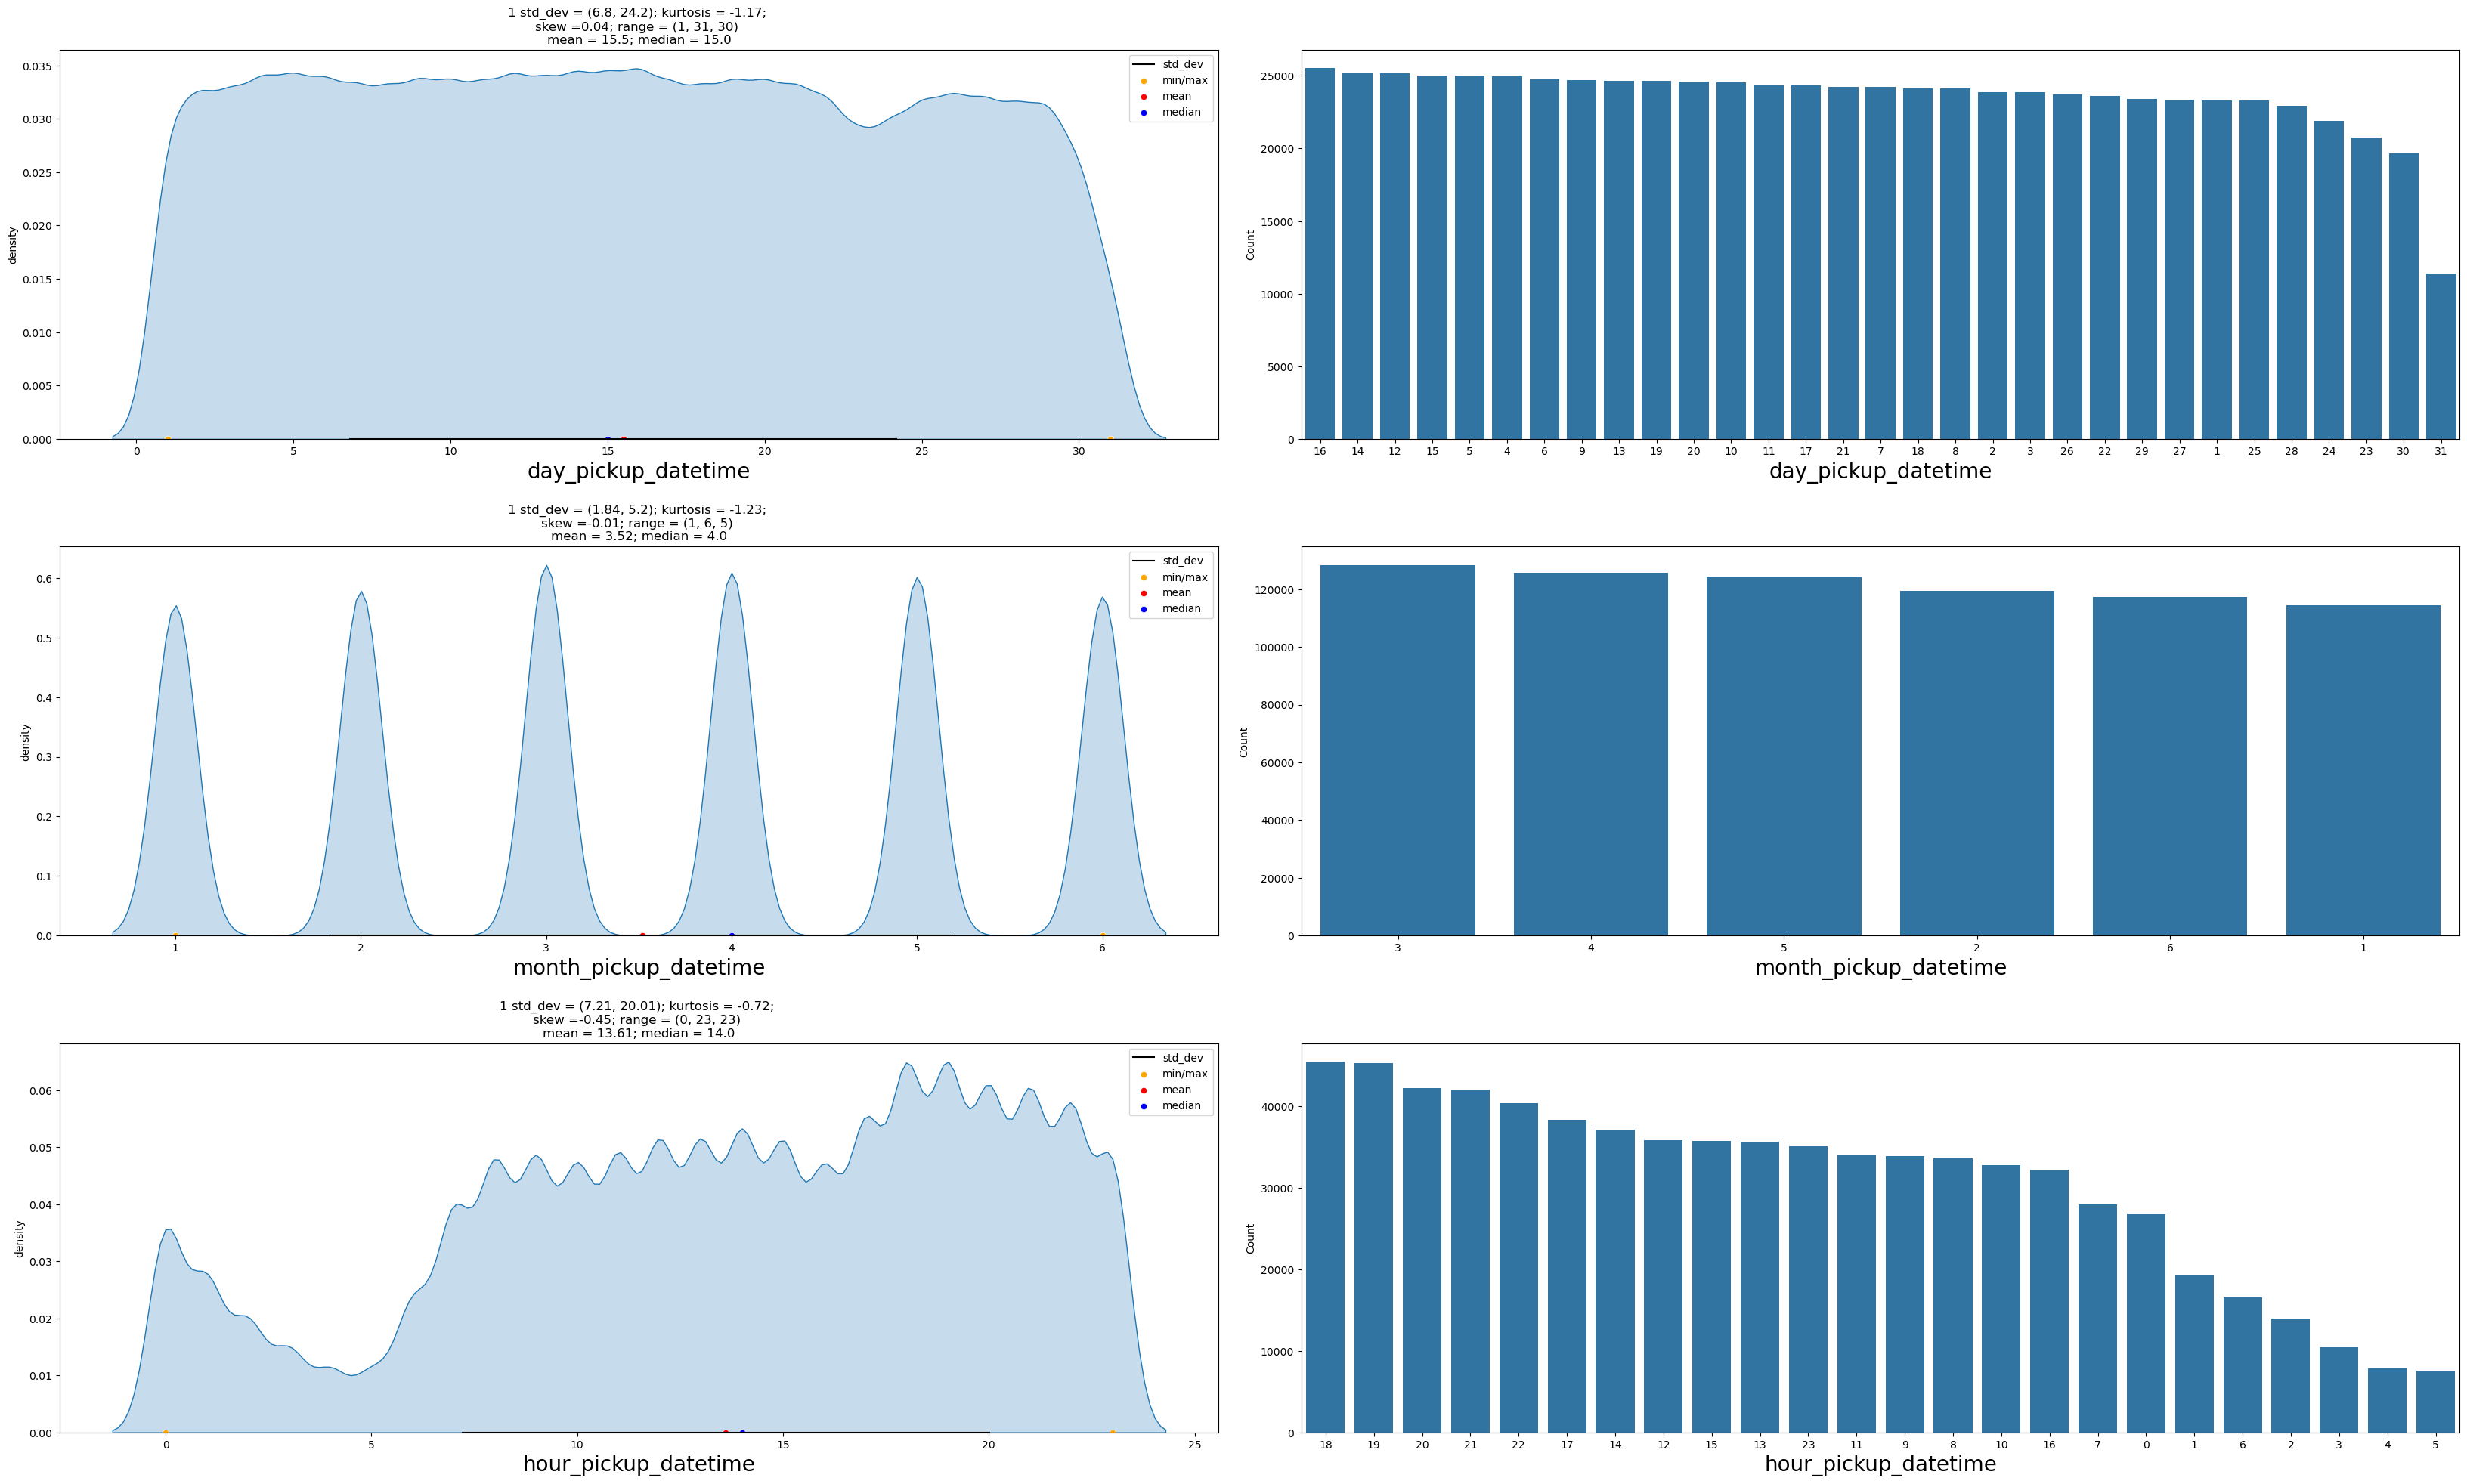

In [17]:
UVA_numeric_discrete(data,pickup_details)

> #### Summary of Pickup trips :Discrete variables

Most of trip pickups took place between:
- **7 and 24 of month** and the highest number of trips occured on **16** of month. 
- **February and May** and the highest number of trips occured on **March**.
- **7h:AM and 8h:PM** and the highest number of trips occured on **6h:PM** of day.

The kurtosis regarding all trip pickups is inferior to zero. So very less likely to have extreme/outlier values.

### Dropoff_details

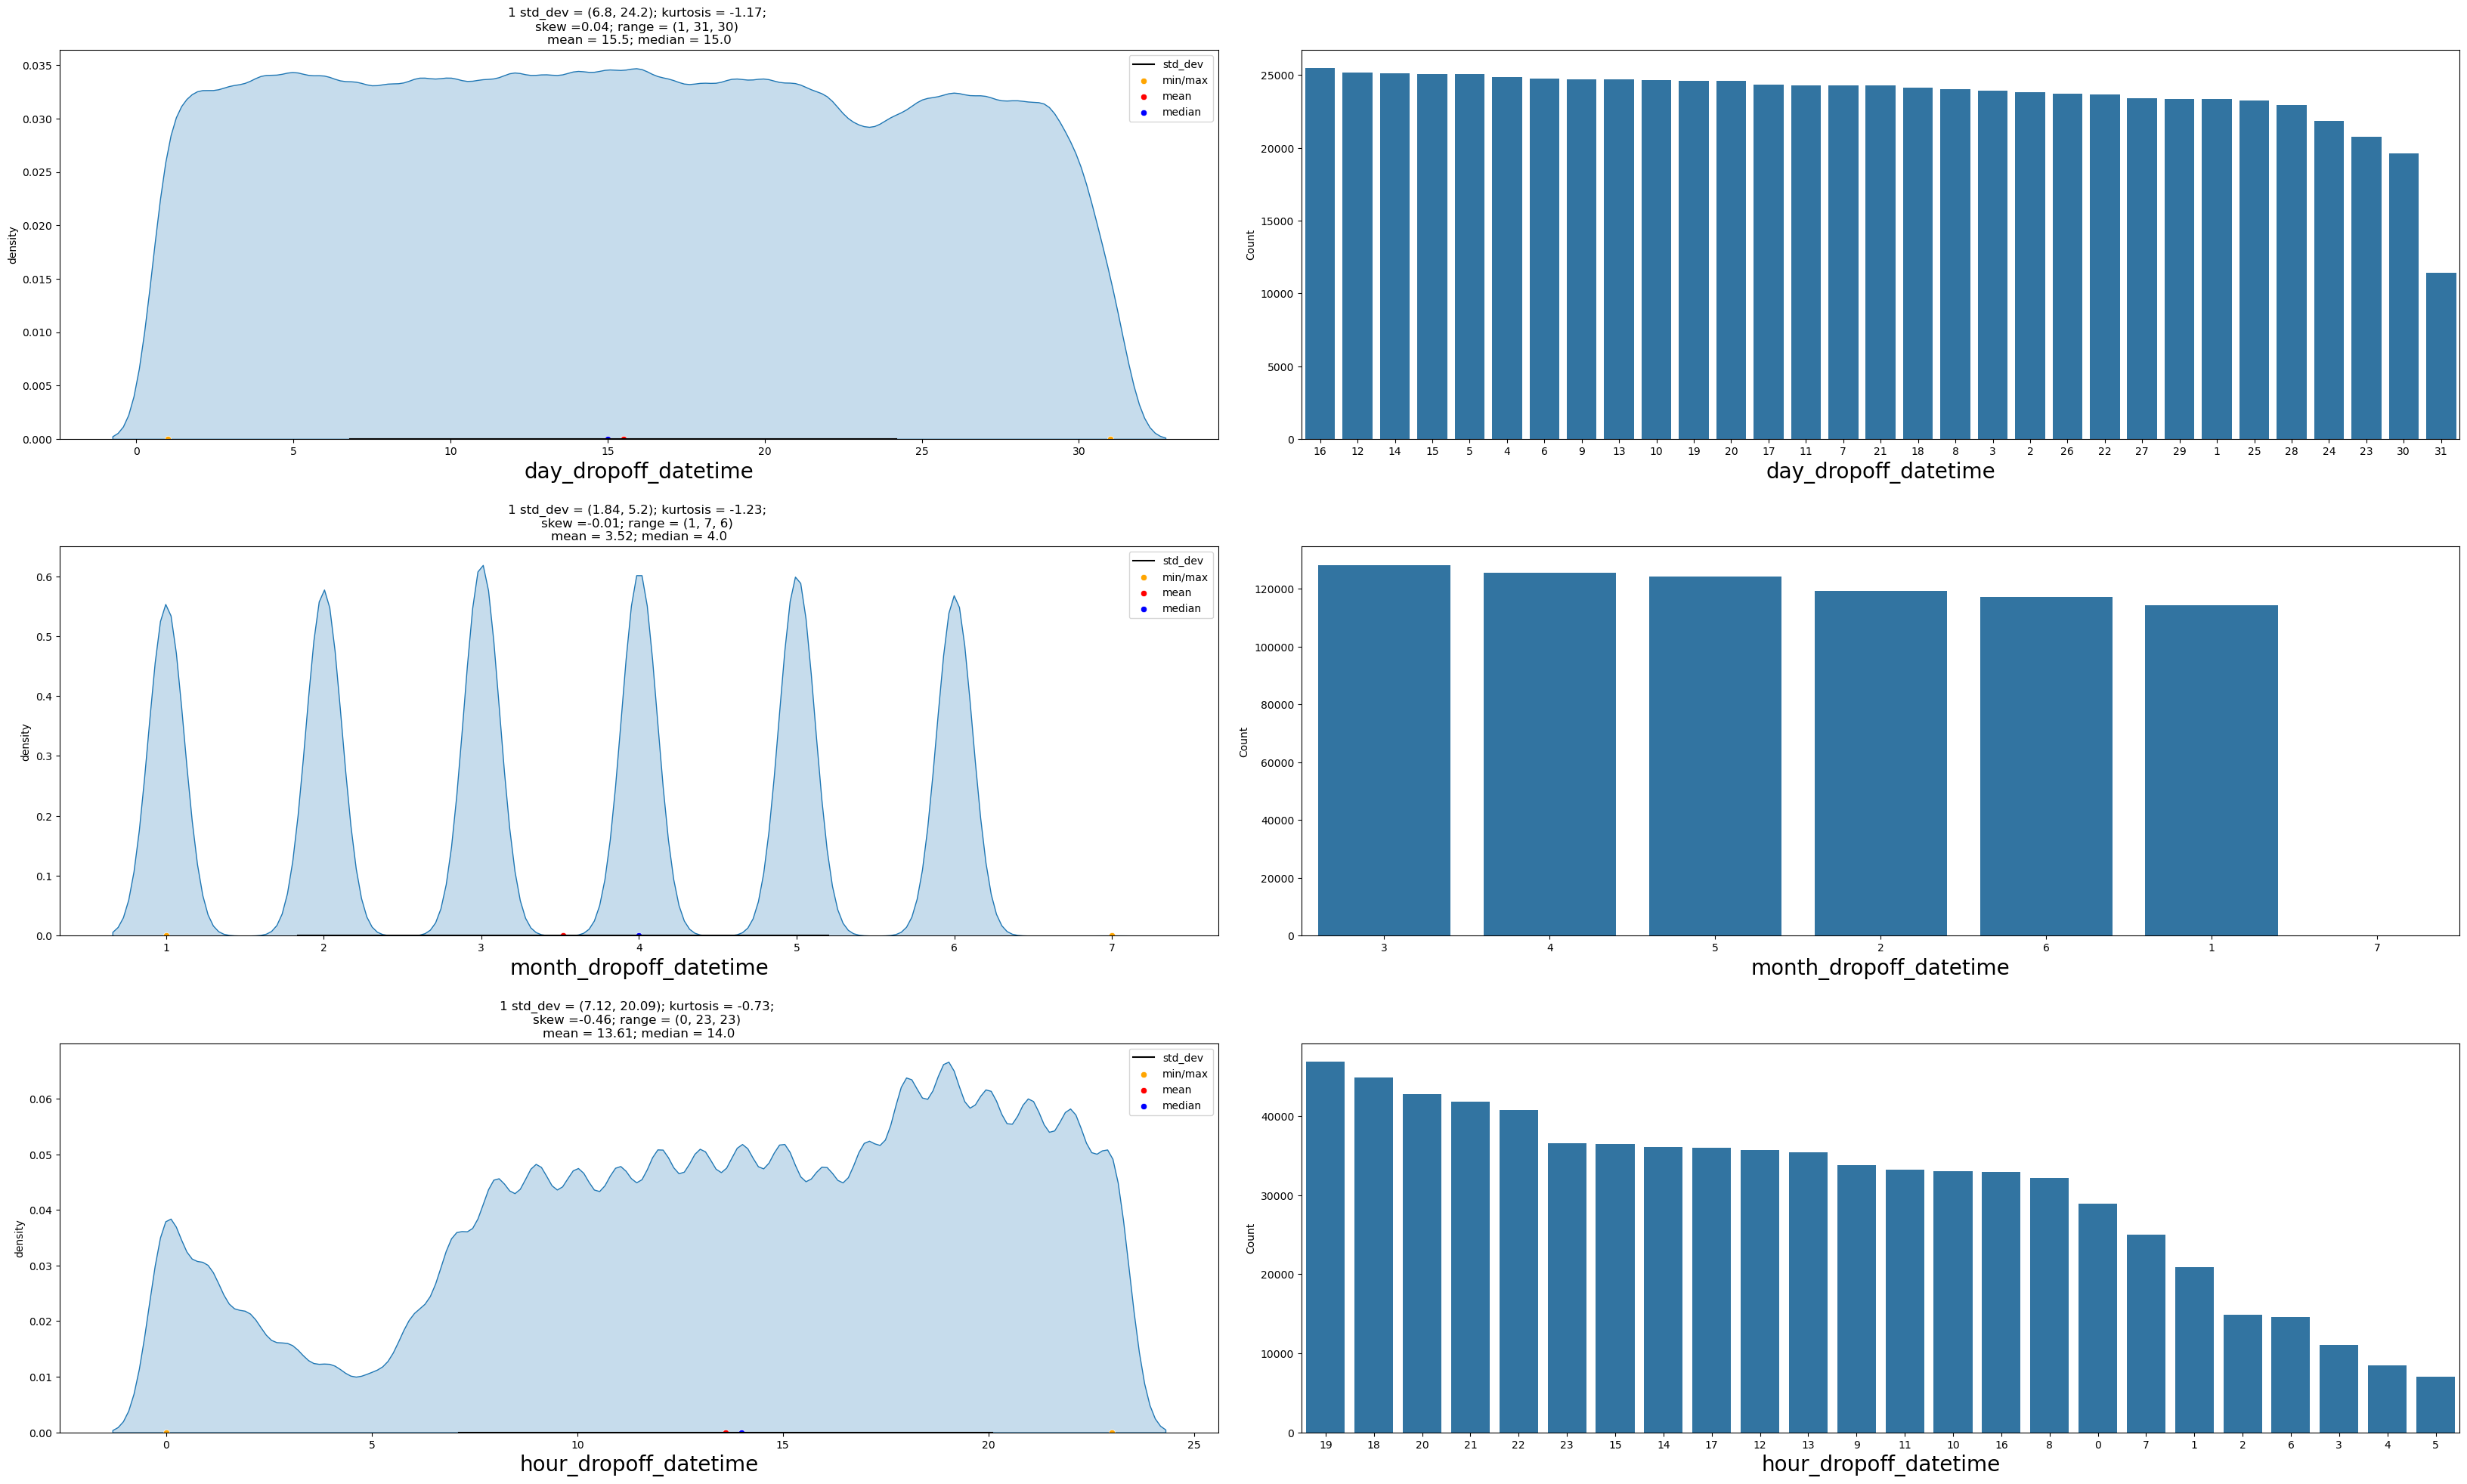

In [18]:
UVA_numeric_discrete(data,dropoff_details)

> #### Summary of Dropoff trips :Discrete variables

Most of trip dropoff took place between:
- **7 and 24 of month** and the highest number of trips occured on **16** of month. 
- **February and May** and the highest number of trips occured on **March**.
- **7h:AM and 8h:PM** and the highest number of trips occured on **7h:PM** of day.

The kurtosis regarding all trip pickups is inferior to zero. So very less likely to have extreme/outlier values.

**Things to investigate further down:**
* There is/are some dropoff made on July. What about this trip? As we now that all pickups occured maximum on June

### Continuous variables

In [19]:
def UVA_numeric_continuous(data, var_group):
    '''
    Univariate analysis numeric for continuous variables
    Takes a group of variables ( INTEGER or FLOAT) and plot/print all the descriptives and properties along with KDE and histograms
    '''
    size = len(var_group)
    fig, ax = plt.subplots(size,2, figsize = [11*size,20])
    
    #looping for each variable
    for j,i in enumerate(var_group):
        
        #computing descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max()-data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()
        
        #calculating points of standard deviation
        points = mean - st_dev, mean + st_dev
        
        #Plotting the variable with every information

        sb.kdeplot(ax = ax[j,0], x = data[i],shade = True)
        sb.lineplot(ax = ax[j,0],x = points,y=[0,0], color = 'black',label = 'std_dev')
        sb.scatterplot(ax=ax[j,0],x = [mini, maxi],y = [0,0],color='orange',label = 'min/max')
        sb.scatterplot(ax=ax[j,0],x = [mean],y = [0], color = 'red',label = "mean")
        sb.scatterplot(ax=ax[j,0],x = [median],y = [0], color = 'blue',label = "median")
        ax[j,0].set_xlabel('{}'.format(i),fontsize = 20)
        ax[j,0].set_ylabel('density')
        ax[j,0].set_title('1 std_dev = {}; kurtosis = {}; \nskew ={}; range = {} \nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                                round(kurt,2),
                                                                                                                round(skew,2),
                                                                                                                (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                                round(mean,2),
                                                                                                                round(median,2)))
                  
    
        base_cl = sb.color_palette()[0]
        pickp_data = data[i].value_counts(ascending=False)
        sb.histplot(data,x = i, color = base_cl,ax= ax[j,1])
        ax[j,1].set_xlabel('{}'.format(i),fontsize = 20)
        #plt.legend(ncol = 2) # re-arrange legend to reduce overlapping"""
        plt.tight_layout(pad =2)


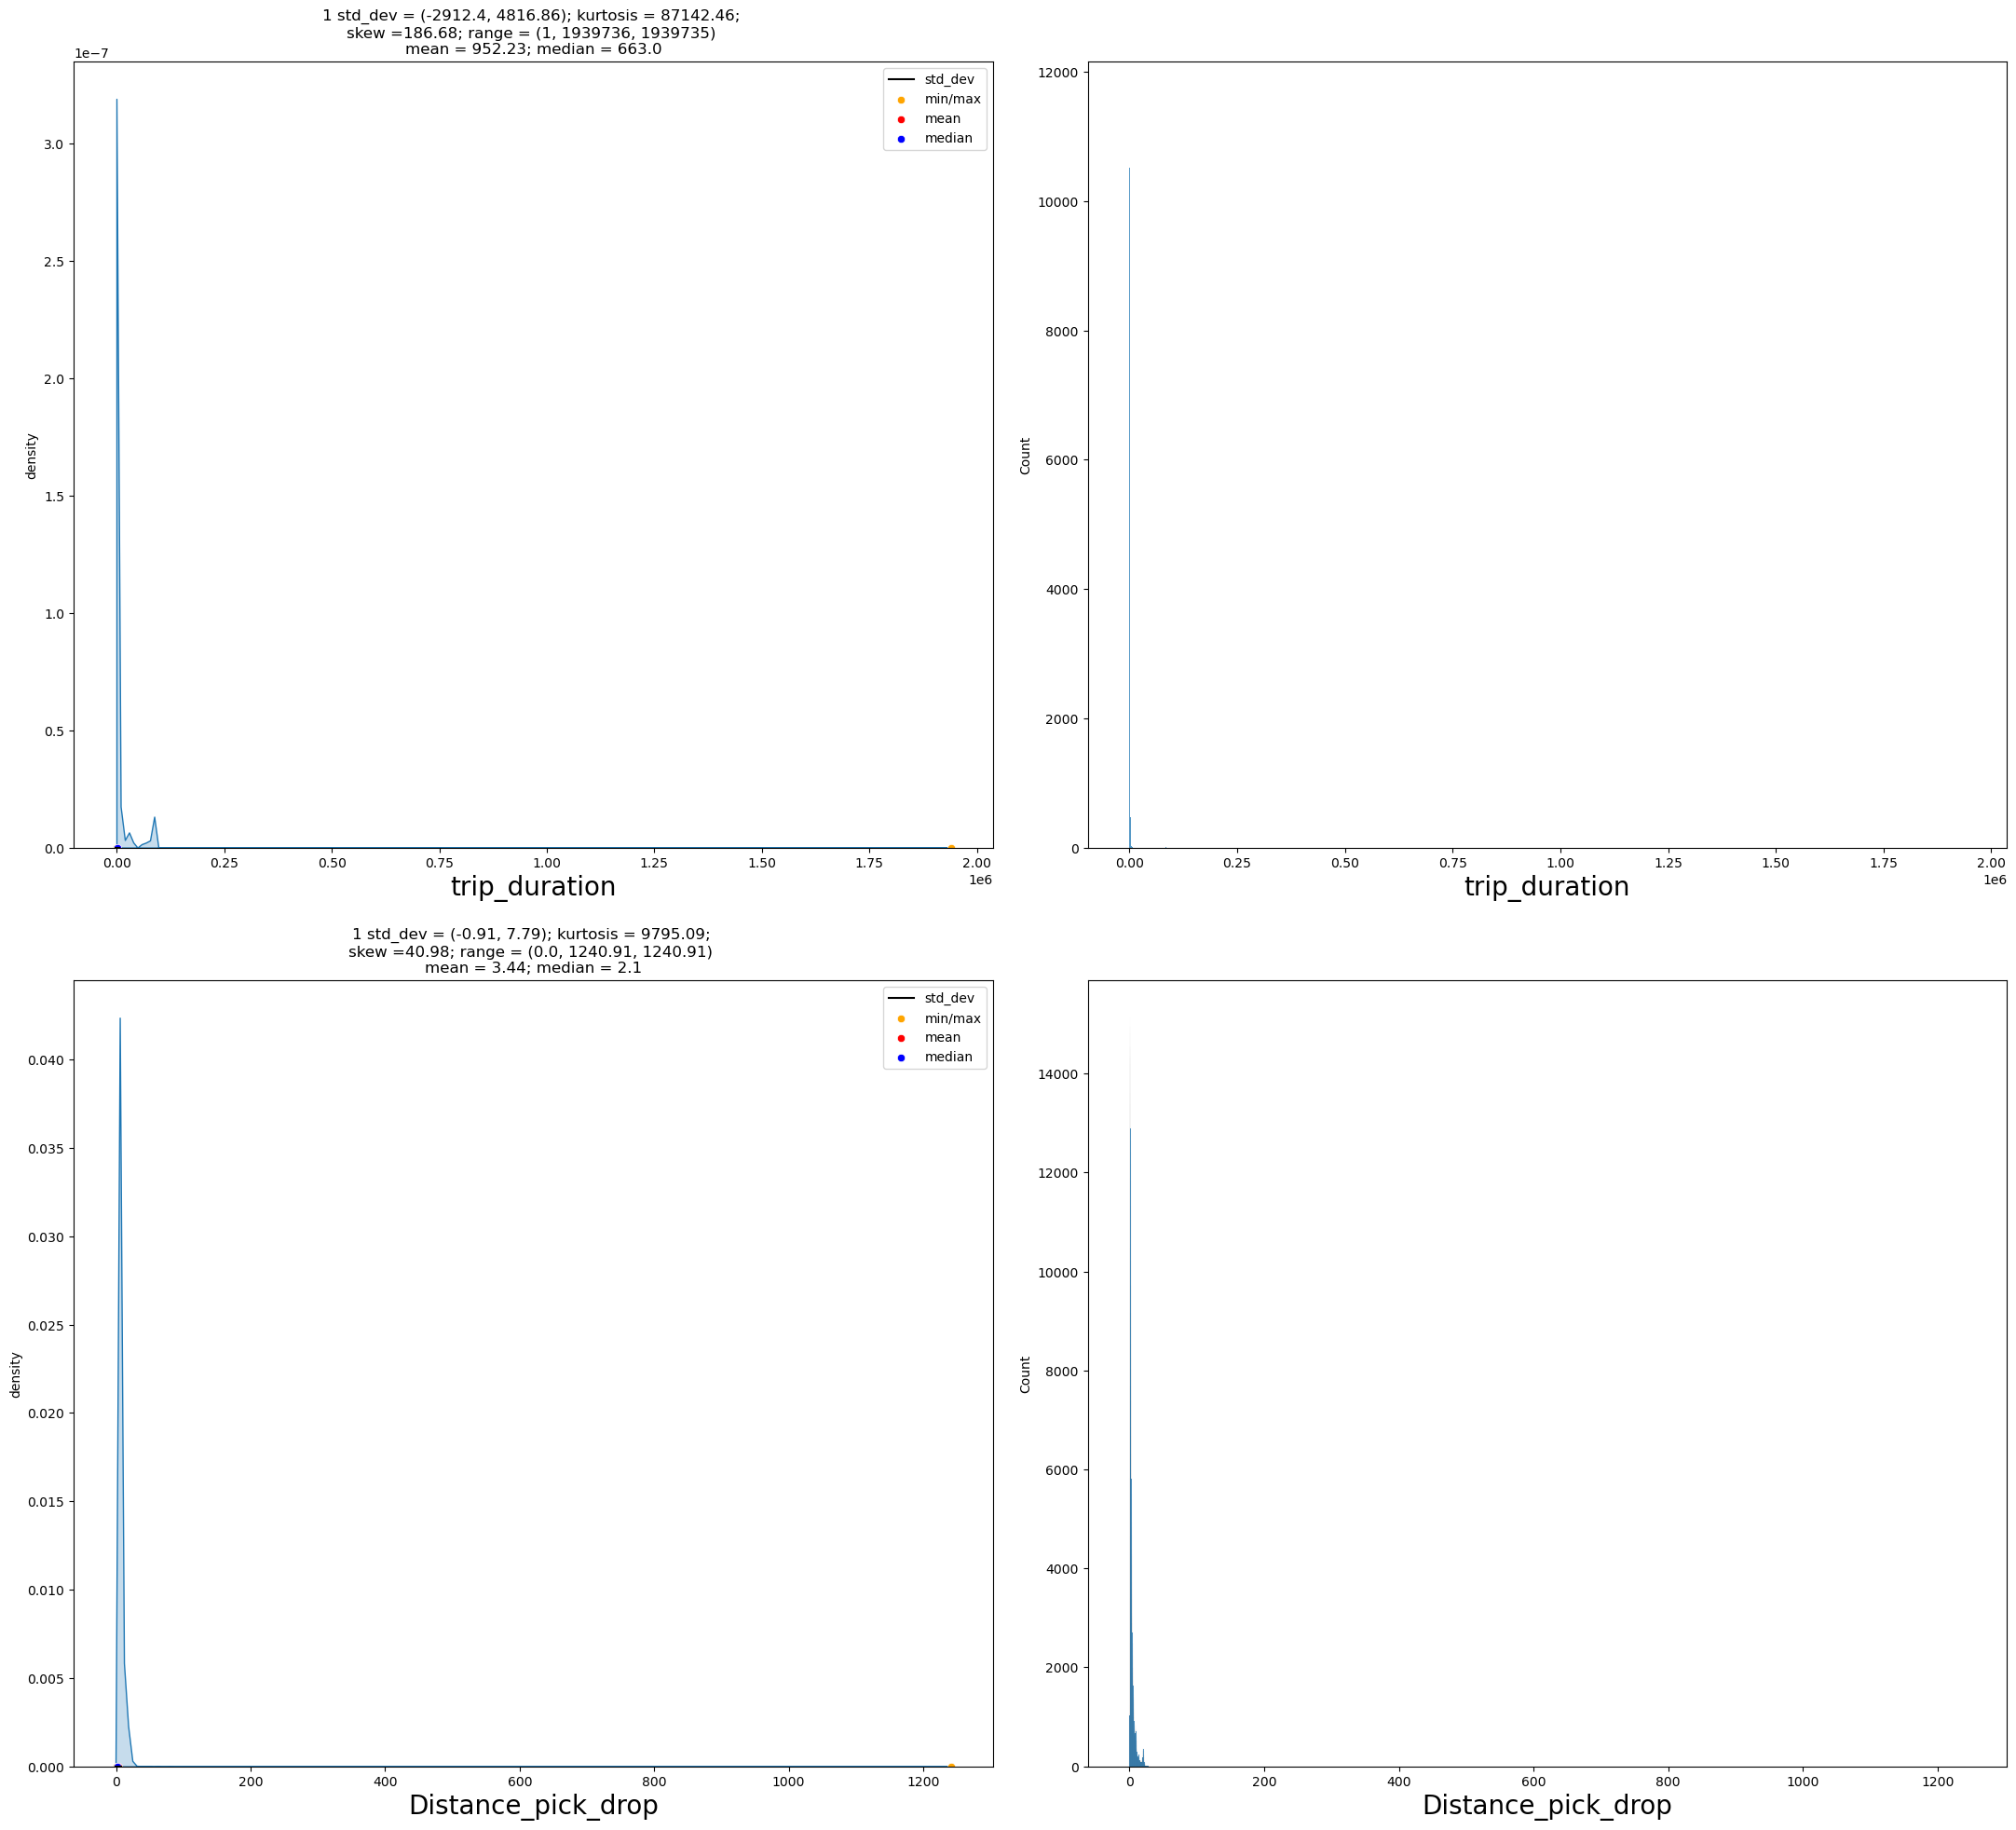

In [20]:
UVA_numeric_continuous(data,trip_details)

In [21]:
data.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count     729322.000000    729322.000000      729322.000000     729322.000000   
mean         -73.973513        40.750919         -73.973422         40.751775   
std            0.069754         0.033594           0.069588          0.036037   
min         -121.933342        34.712234        -121.933304         32.181141   
25%          -73.991859        40.737335         -73.991318         40.735931   
50%          -73.981758        40.754070         -73.979759         40.754509   
75%          -73.967361        40.768314         -73.963036         40.769741   
max          -65.897385        51.881084         -65.897385         43.921028   

       trip_duration  day_pickup_datetime  month_pickup_datetime  \
count   7.293220e+05        729322.000000          729322.000000   
mean    9.522291e+02            15.502088               3.518410   
std     3.864626e+03             8.699772               1.680661   
min     1.000000e+00             1.000000               1.000000   
25%     3.970000e+02             8.000000               2.000000   
50%     6.630000e+02            15.000000               4.000000   
75%     1.075000e+03            23.000000               5.000000   
max     1.939736e+06            31.000000               6.000000   

       hour_pickup_datetime  day_dropoff_datetime  month_dropoff_datetime  \
count         729322.000000         729322.000000           729322.000000   
mean              13.611698             15.502587                3.518764   
std                6.402853              8.699714                1.680815   
min                0.000000              1.000000                1.000000   
25%                9.000000              8.000000                2.000000   
50%               14.000000             15.000000                4.000000   
75%               19.000000             23.000000                5.000000   
max               23.000000             31.000000                7.000000   

       hour_dropoff_datetime  Distance_pick_drop  
count           729322.00000       729322.000000  
mean                13.60616            3.441139  
std                  6.48637            4.353132  
min                  0.00000            0.000000  
25%                  9.00000            1.232695  
50%                 14.00000            2.095672  
75%                 19.00000            3.876481  
max                 23.00000         1240.908677

> #### Summary of duration trip :Continuous variable

The trip duration and distance have a longer distribution and highly skewed at right. Their kurtosis is also very higher, we could find a lot of extreme values.

The mean duration trip is 952.23 seconds so about 15 minutes and 52 seconds.

**Things to investigate further down:**
* Probably very unlikely outliers like the maximums and minimums regarding trip details:
    * Minimum of trip duration of 1s, maximum of 1939736 s about 22 days 11hours
    * Minimum of distance inferiror to 1 KM

---

## Univariate analysis : Categorical variables

In [22]:
data.select_dtypes(exclude=['int64','float64','Int64']).dtypes

vendor_id             category
passenger_count       category
store_and_fwd_flag    category
dtype: object

Let's add a new category by clustering the taxi hours peaks.

In [23]:
data['day_moments'] = 'to_fill'
data['day_moments'][(data.hour_pickup_datetime >=0) & (data.hour_pickup_datetime < 6)] = 'Full_night'
data['day_moments'][(data.hour_pickup_datetime >= 6) & (data.hour_pickup_datetime < 10)] = 'Early_morning'
data['day_moments'][(data.hour_pickup_datetime >= 10) & (data.hour_pickup_datetime < 13)] = 'Middle_morning'
data['day_moments'][(data.hour_pickup_datetime >= 13) & (data.hour_pickup_datetime < 18)] = 'Afternoon'
data['day_moments'][(data.hour_pickup_datetime >= 18) & (data.hour_pickup_datetime <= 23)] = 'Evening'
data['day_moments']=data['day_moments'].astype('category') 

In [24]:
def UVA_category(data, var_group, max_categories=10):

    '''
    Univariate_Analysis_categorical
    takes a group of variables (category) and plot/print the value_counts and barplot for max_categories.
    '''
    # setting figure_size
    size = len(var_group)
    plt.figure(figsize = (7*size,35), dpi=100)

    # for every variable
    for j,i in enumerate(var_group):
        norm_count = data[i].value_counts(normalize = True)[:max_categories]
        n_uni = data[i].nunique()

        #Plotting the variable with every information
        plt.subplot(4,1,j+1)
        color_base = sb.color_palette()[0]
        sb.barplot(x=norm_count, y=norm_count.index , order=norm_count.index, color = color_base)
        plt.xlabel('fraction/percent', fontsize = 20)
        plt.ylabel(f'{i}', fontsize = 20)
        plt.title(f'n_uniques = {n_uni} \n value counts \n {norm_count}')
        plt.tight_layout(pad=3)

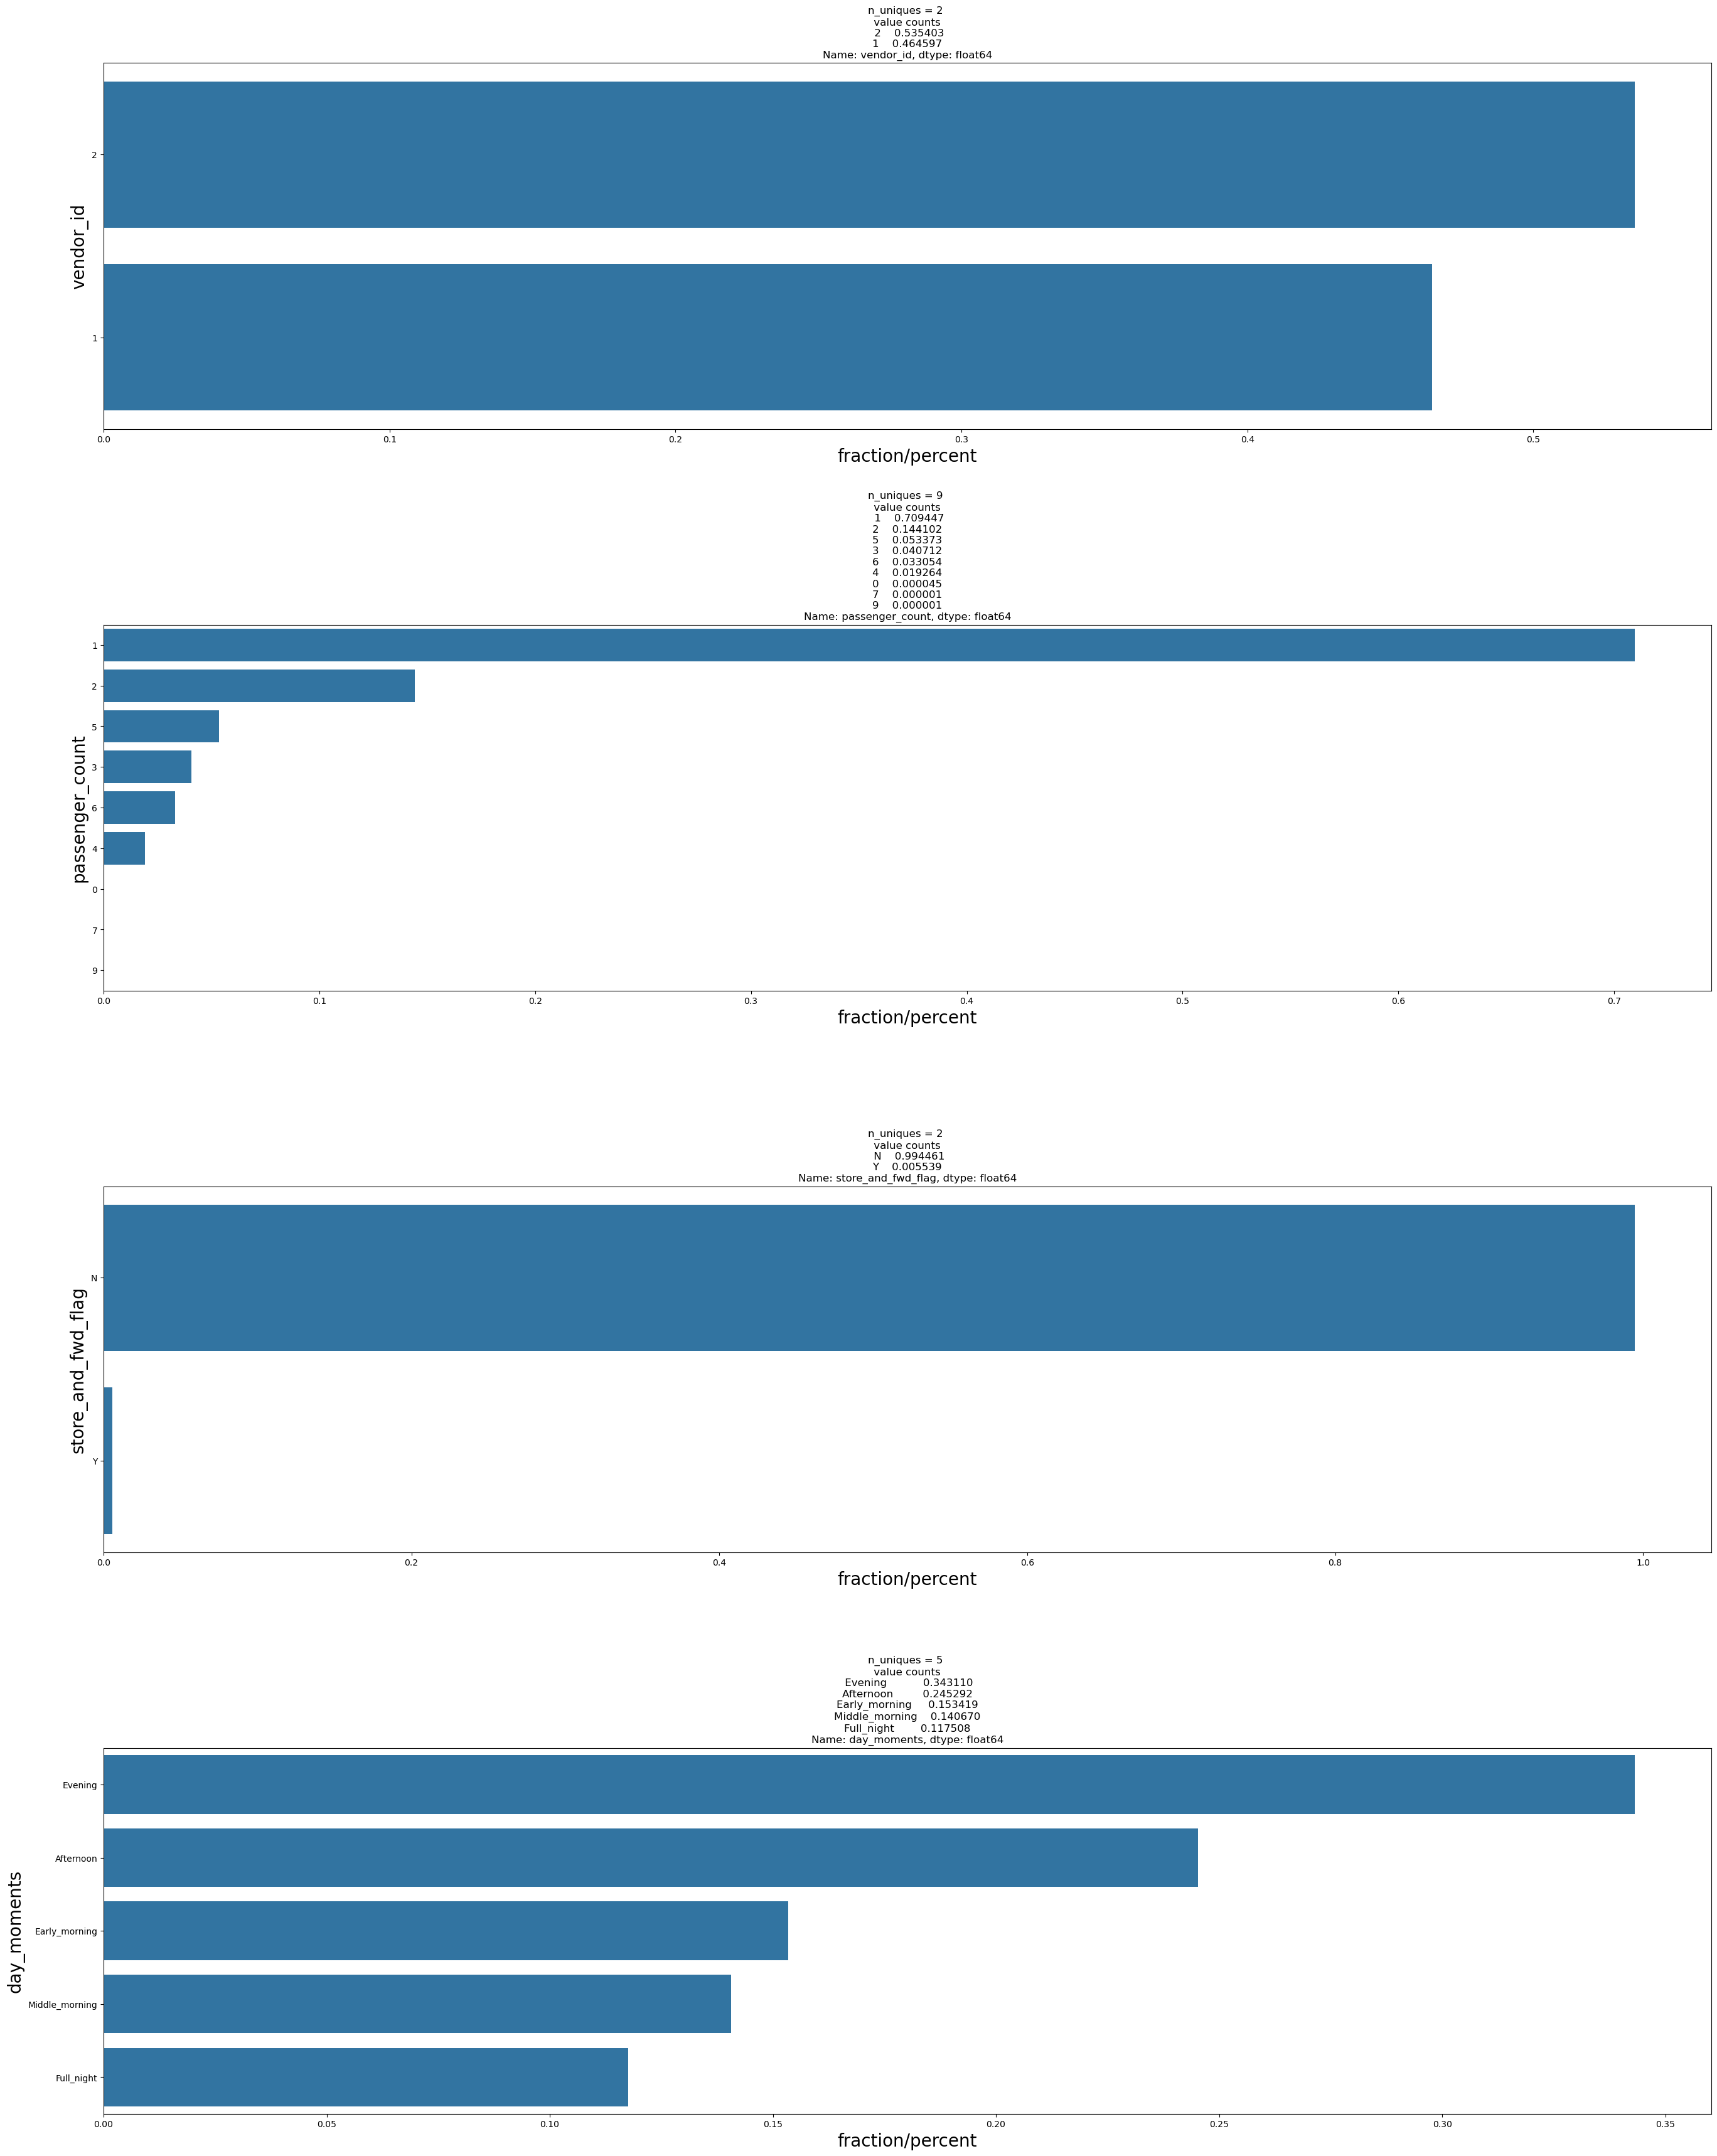

In [25]:
UVA_category(data,['vendor_id','passenger_count','store_and_fwd_flag','day_moments'])

> #### Summary of categorical variables:

**Vendor_id**
* One of taxi vendors have a little more than half taxi in NYC. But this variable don't help us in trip duration analysis. We can drop it.

**Passenger counts**
* Most of taxi took one or two passengers. We should only consider the taxi with at least one passenger.

**strore_and_fwd_flag**
* Very few taxi store in vehicle memory before send to server. So we could assume that the connexion is most of the time good no matter the climate. This variable is no longer important for our analysis. 

**day_moments**
* Most of trips started at by the end of afternoon and during evening **34%**.After during afternoon with **24%** and early in morning with **15%**.


## Univariate Analysis: Outliers

I suspect a lot of outliers in trip duration, distance between pickup and dropoff locations.

In [26]:
# custom function for easy outlier analysis

def UVA_outlier(data, var_group,include_outliers=True):
    '''
    Univariate_Analysis_outlier:
    takes a group of variables (INTEGER and FLOAT) and plot/print boxplot and descriptives
    Runs a loop: calculate all the descriptives of i-th variable and plot/print it

    data : dataframe from which to plot from
    var_group : [list] Group of Continuous variables
    include_outlier : [bool] whether to include outliers or not, default = True
    '''

    size = len(var_group)
    plt.figure(figsize = (7*size,4), dpi = 100)

    #looping for each variable
    for j,i in enumerate(var_group):

        # calculating descriptives of variable
        quant25 = round(data[i].quantile(0.25), 2)
        quant75 = round(data[i].quantile(0.75), 2)
        IQR = round(quant75 - quant25, 2)
        med = round(data[i].median(), 2)
        whis_low = quant25-(1.5*IQR)
        whis_high = quant75+(1.5*IQR)

        # Calculating Number of Outliers
        outlier_high = len(data[i][data[i]>whis_high])
        outlier_low = len(data[i][data[i]<whis_low])
        
        if include_outliers == True:
            #Plotting the variable with every information
            plt.subplot(1,size,j+1)
            sb.boxplot(data=data[i], orient="v")
            plt.ylabel(f'{i}')
            plt.title(f'With Outliers\nIQR = {IQR}; Median = {med}\n 1st,3rd quartile = {quant25, quant75};\n Outliers(low/high) = {(outlier_low,outlier_high)}')
      
        else:
            # replacing outliers with max/min whisker
            data2 = data[var_group][:]
            data2[i][data2[i]>whis_high] = whis_high
            data2[i][data2[i]<whis_low] = whis_low

            # plotting without outliers
            plt.subplot(1,size,j+1)
            sb.boxplot(data=data2[i], orient="v")
            plt.ylabel(f'{i}')
            plt.title(f'Without Outliers\nIQR = {IQR}; Median = {med}\n 1st,3rd quartile = {quant25, quant75}')

#### Pickup details

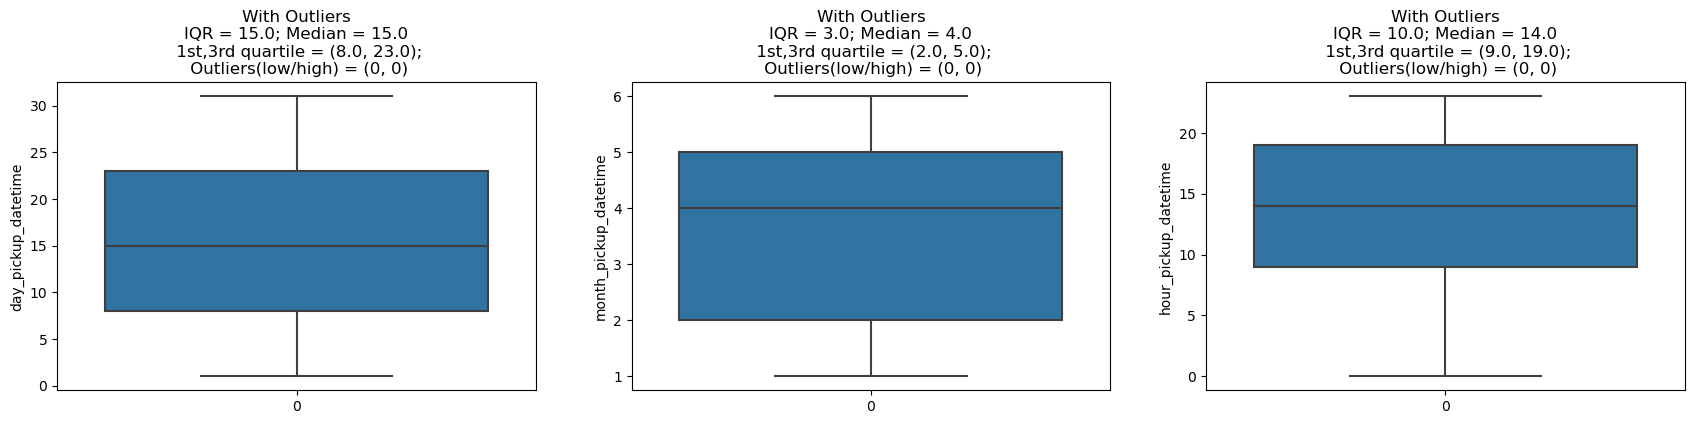

In [27]:
UVA_outlier(data,pickup_details,include_outliers=True)

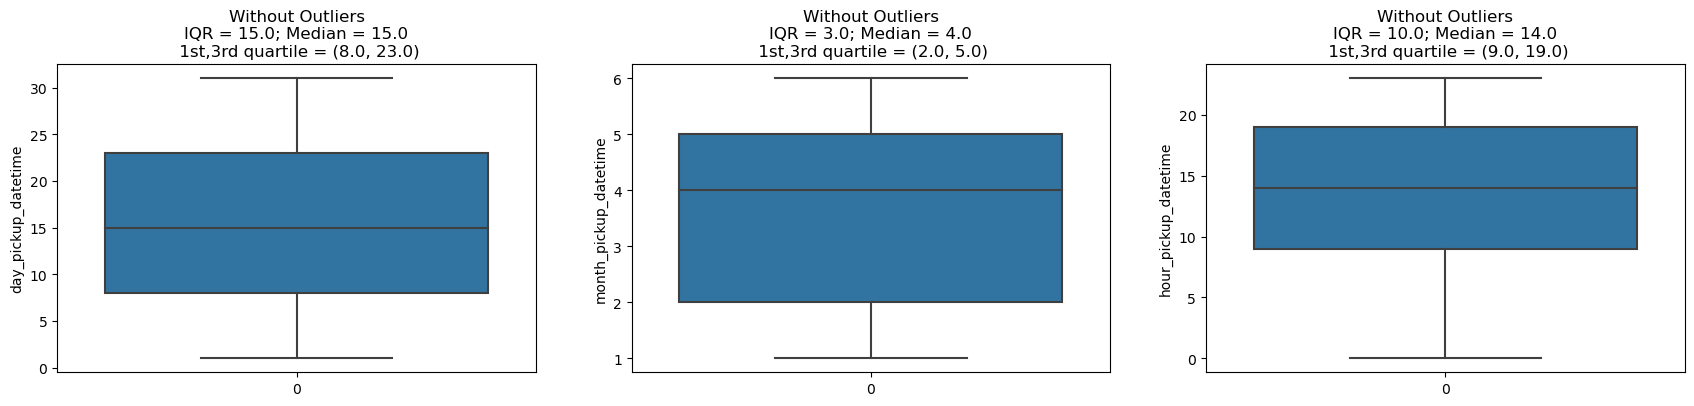

In [28]:
UVA_outlier(data,pickup_details,include_outliers=False)

#### Dropoff details

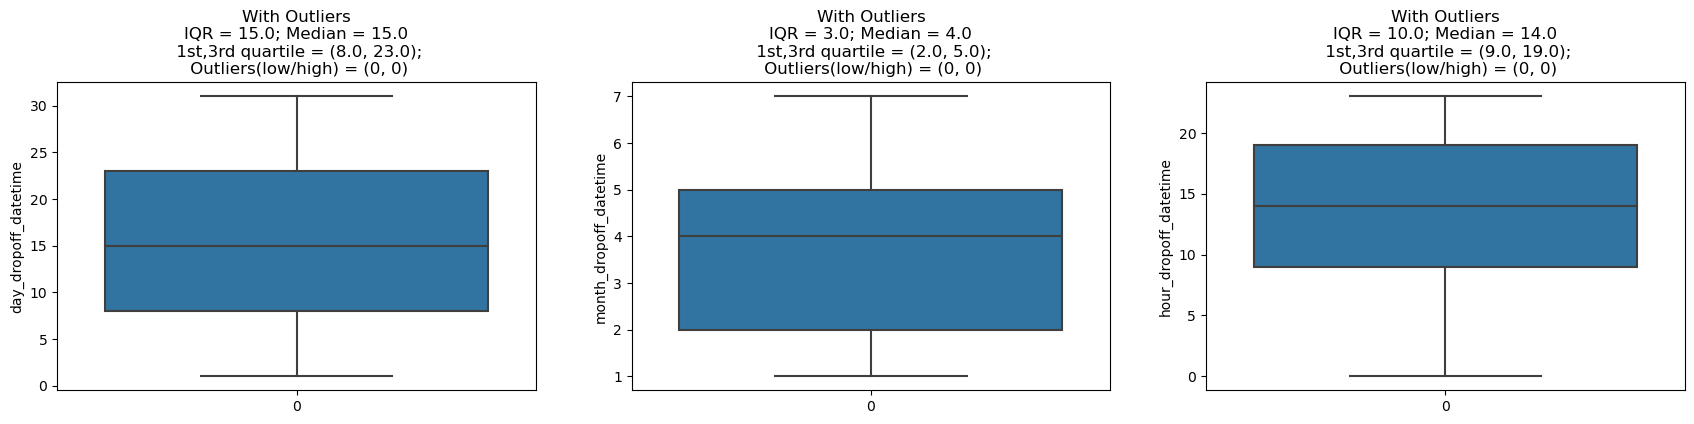

In [29]:
UVA_outlier(data, dropoff_details, include_outliers = True)

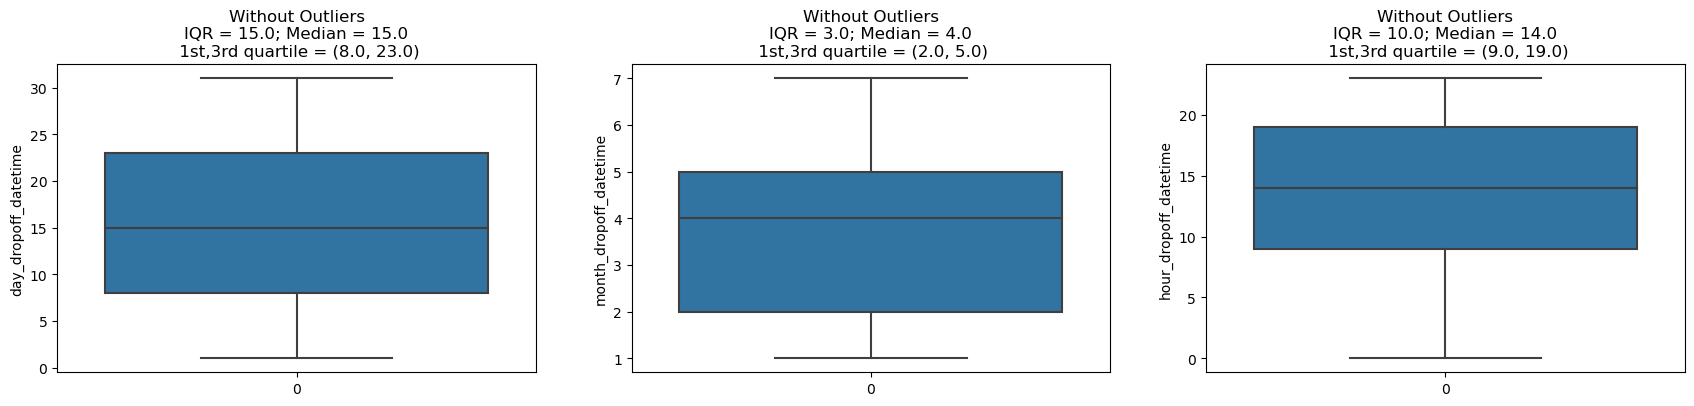

In [30]:
UVA_outlier(data, dropoff_details, include_outliers = False)

### Trip details

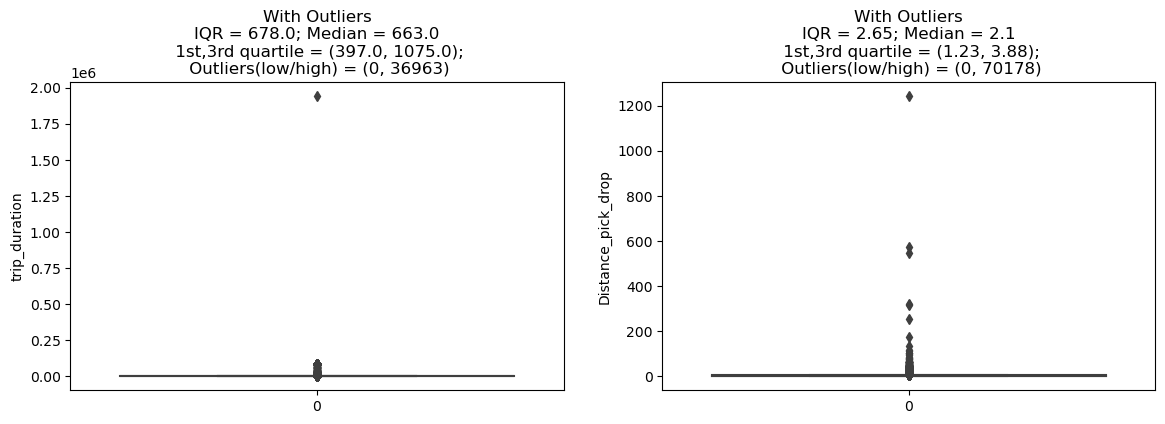

In [31]:
UVA_outlier(data, trip_details, include_outliers = True)

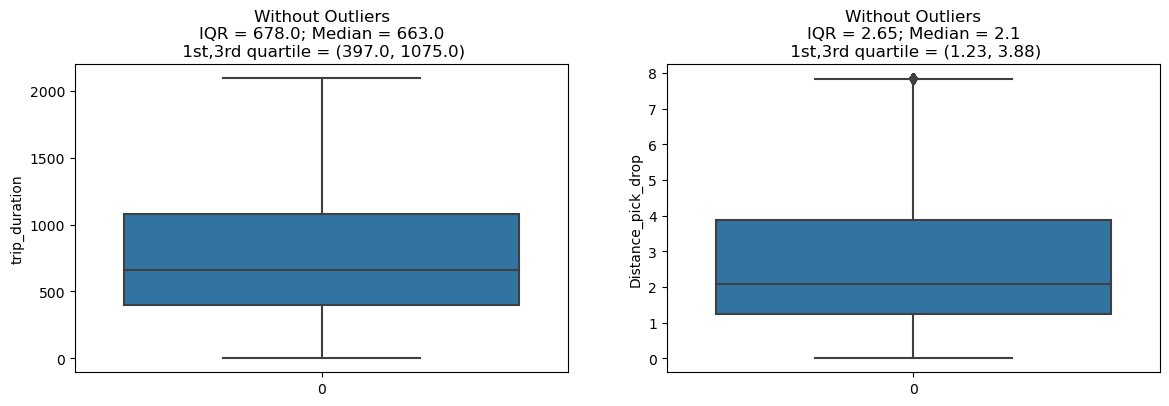

In [32]:
UVA_outlier(data, trip_details, include_outliers = False)

In [33]:
# Examples of wierd values
data[data.trip_duration >42200] #More than 12 hours of traffic but a very small distance traveled 

vendor_id passenger_count  pickup_longitude  pickup_latitude  \
15             2               1        -74.002876        40.734131   
610            2               6        -73.990753        40.730415   
3018           2               1        -73.981789        40.746292   
3543           2               1        -73.974472        40.753895   
4716           2               1        -74.000954        40.741982   
...          ...             ...               ...              ...   
726094         2               5        -73.978630        40.762920   
726171         2               1        -73.996918        40.752659   
726781         2               1        -74.005913        40.742966   
727618         2               1        -73.988434        40.753716   
728214         2               1        -73.998222        40.735279   

        dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
15             -73.955399         40.767502                  N          86164   
610            -73.968506         40.750965                  N          59458   
3018           -73.984619         40.763962                  N          86342   
3543           -73.971481         40.795464                  N          86145   
4716           -73.966263         40.763000                  N          86268   
...                   ...               ...                ...            ...   
726094         -73.947388         40.711311                  N          85962   
726171         -74.003098         40.718094                  N          84188   
726781         -73.978806         40.761127                  N          86123   
727618         -74.000610         40.720901                  N          85741   
728214         -73.975128         40.792549                  N          86007   

        day_pickup_datetime  month_pickup_datetime  hour_pickup_datetime  \
15                       21                      2                     1   
610                      13                      1                     7   
3018                     17                      6                    12   
3543                     13                      4                    22   
4716                     26                      4                    16   
...                     ...                    ...                   ...   
726094                   11                      4                    20   
726171                   16                      3                    12   
726781                   27                      3                     1   
727618                    5                      4                    13   
728214                    2                      3                    17   

        day_dropoff_datetime  month_dropoff_datetime  hour_dropoff_datetime  \
15                        22                       2                      1   
610                       14                       1                      0   
3018                      18                       6                     12   
3543                      14                       4                     22   
4716                      27                       4                     16   
...                      ...                     ...                    ...   
726094                    12                       4                     20   
726171                    17                       3                     11   
726781                    28                       3                      1   
727618                     6                       4                     12   
728214                     3                       3                     17   

        Distance_pick_drop     day_moments  
15                5.455636      Full_night  
610               2.955407   Early_morning  
3018              1.979191  Middle_morning  
3543              4.629090         Evening  
4716              3.741861       Afternoon  
...                    ...             ...  
7260

> #### Summary of outliers detection 

* If we look at corresponding plots in the outputs above, there seems to be a strong relation between the corresponding plots of pickup details and dropoff details variables.
* Outliers are significant in number on trip duration and trip distance. Which indicates some inherent undiscovered behaviour of Outliers.Probably the taximan incountered some issues with the device of trip value estimator, or just forgot to stop the device at the end of his trip.

### Investigation directions from Univariate Analysis
1. vendor_id, strore_and_fwd_flag,pickup_latitude, pickup_longitude,dropoff_longitude, dropoff_latitude variables can be dropped.
2.  Is there there any common trait/relation between the pickup and dropoff moments?
    * The plots show us that they are very similar. That looks logical because we choose the taxi to go faster from a A point to B point. 
3. The outliers are in number in data. We should manage them to justify the pickup and dropoff moments.
4. We should remove from data , trips without passengers, non-significative distances, and replace outliers in trip duration and distance between pickup and dropoff locations.



In [34]:
data.drop(data[data.Distance_pick_drop <=0.001].index, inplace = True)

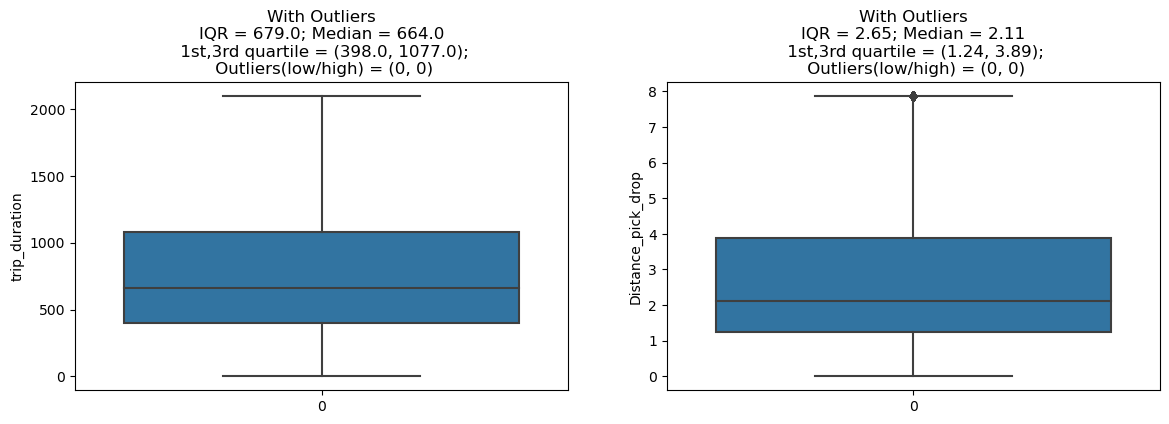

In [35]:
for j,i in enumerate(trip_details):
    quant25 = round(data[i].quantile(0.25), 2)
    quant75 = round(data[i].quantile(0.75), 2)
    IQR = round(quant75 - quant25, 2)
    whis_low = quant25-(1.5*IQR)
    whis_high = quant75+(1.5*IQR)

    data[i][data[i]>whis_high] = whis_high
    data[i][data[i]<whis_low] = whis_low
UVA_outlier(data, trip_details, include_outliers = True)

In [36]:
data.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'day_pickup_datetime', 'month_pickup_datetime',
       'hour_pickup_datetime', 'day_dropoff_datetime',
       'month_dropoff_datetime', 'hour_dropoff_datetime', 'Distance_pick_drop',
       'day_moments'],
      dtype='object')

In [37]:
data = data.drop(columns = ['vendor_id','store_and_fwd_flag','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'])
data = data.drop(data[data['passenger_count'] == 0].index)
data.columns


Index(['passenger_count', 'trip_duration', 'day_pickup_datetime',
       'month_pickup_datetime', 'hour_pickup_datetime', 'day_dropoff_datetime',
       'month_dropoff_datetime', 'hour_dropoff_datetime', 'Distance_pick_drop',
       'day_moments'],
      dtype='object')

In [38]:
data.describe()

trip_duration  day_pickup_datetime  month_pickup_datetime  \
count  726075.000000        726075.000000          726075.000000   
mean      802.864444            15.502842               3.518349   
std       528.874250             8.699567               1.680506   
min         1.000000             1.000000               1.000000   
25%       398.000000             8.000000               2.000000   
50%       664.000000            15.000000               4.000000   
75%      1077.000000            23.000000               5.000000   
max      2095.500000            31.000000               6.000000   

       hour_pickup_datetime  day_dropoff_datetime  month_dropoff_datetime  \
count         726075.000000         726075.000000           726075.000000   
mean              13.612778             15.503314                3.518704   
std                6.402489              8.699506                1.680661   
min                0.000000              1.000000                1.000000   
25%                9.000000              8.000000                2.000000   
50%               14.000000             15.000000                4.000000   
75%               19.000000             23.000000                5.000000   
max               23.000000             31.000000                7.000000   

       hour_dropoff_datetime  Distance_pick_drop  
count          726075.000000       726075.000000  
mean               13.607282            2.916481  
std                 6.486179            2.247042  
min                 0.000000            0.001062  
25%                 9.000000            1.242392  
50%                14.000000            2.105738  
75%                19.000000            3.889779  
max                23.000000            7.865000

## Bivariate analysis : Numerical-Numerical

In [39]:
# isolating numerical datatypes
numerical = data.select_dtypes(include=['int64','float64','Int64'])[:]
numerical.dtypes

trip_duration             float64
day_pickup_datetime         int64
month_pickup_datetime       int64
hour_pickup_datetime        int64
day_dropoff_datetime        int64
month_dropoff_datetime      int64
hour_dropoff_datetime       int64
Distance_pick_drop        float64
dtype: object

### Correlation Matrix

In [40]:
# calculating correlation
correlation = numerical.corr()
correlation

trip_duration  day_pickup_datetime  \
trip_duration                1.000000             0.010396   
day_pickup_datetime          0.010396             1.000000   
month_pickup_datetime        0.057363            -0.014995   
hour_pickup_datetime         0.032570            -0.001635   
day_dropoff_datetime         0.010163             0.997903   
month_dropoff_datetime       0.057591            -0.014633   
hour_dropoff_datetime        0.033653            -0.001746   
Distance_pick_drop           0.789171             0.007521   

                        month_pickup_datetime  hour_pickup_datetime  \
trip_duration                        0.057363              0.032570   
day_pickup_datetime                 -0.014995             -0.001635   
month_pickup_datetime                1.000000             -0.003308   
hour_pickup_datetime                -0.003308              1.000000   
day_dropoff_datetime                -0.015091             -0.001500   
month_dropoff_datetime               0.999937             -0.003049   
hour_dropoff_datetime               -0.004014              0.934466   
Distance_pick_drop                   0.020719             -0.028112   

                        day_dropoff_datetime  month_dropoff_datetime  \
trip_duration                       0.010163                0.057591   
day_pickup_datetime                 0.997903               -0.014633   
month_pickup_datetime              -0.015091                0.999937   
hour_pickup_datetime               -0.001500               -0.003049   
day_dropoff_datetime                1.000000               -0.015442   
month_dropoff_datetime             -0.015442                1.000000   
hour_dropoff_datetime              -0.001951               -0.004389   
Distance_pick_drop                  0.007355                0.020911   

                        hour_dropoff_datetime  Distance_pick_drop  
trip_duration                        0.033653            0.789171  
day_pickup_datetime                 -0.001746            0.007521  
month_pickup_datetime               -0.004014            0.020719  
hour_pickup_datetime                 0.934466           -0.028112  
day_dropoff_datetime                -0.001951            0.007355  
month_dropoff_datetime              -0.004389            0.020911  
hour_dropoff_datetime                1.000000           -0.037636  
Distance_pick_drop                  -0.037636            1.000000

### Heatmap

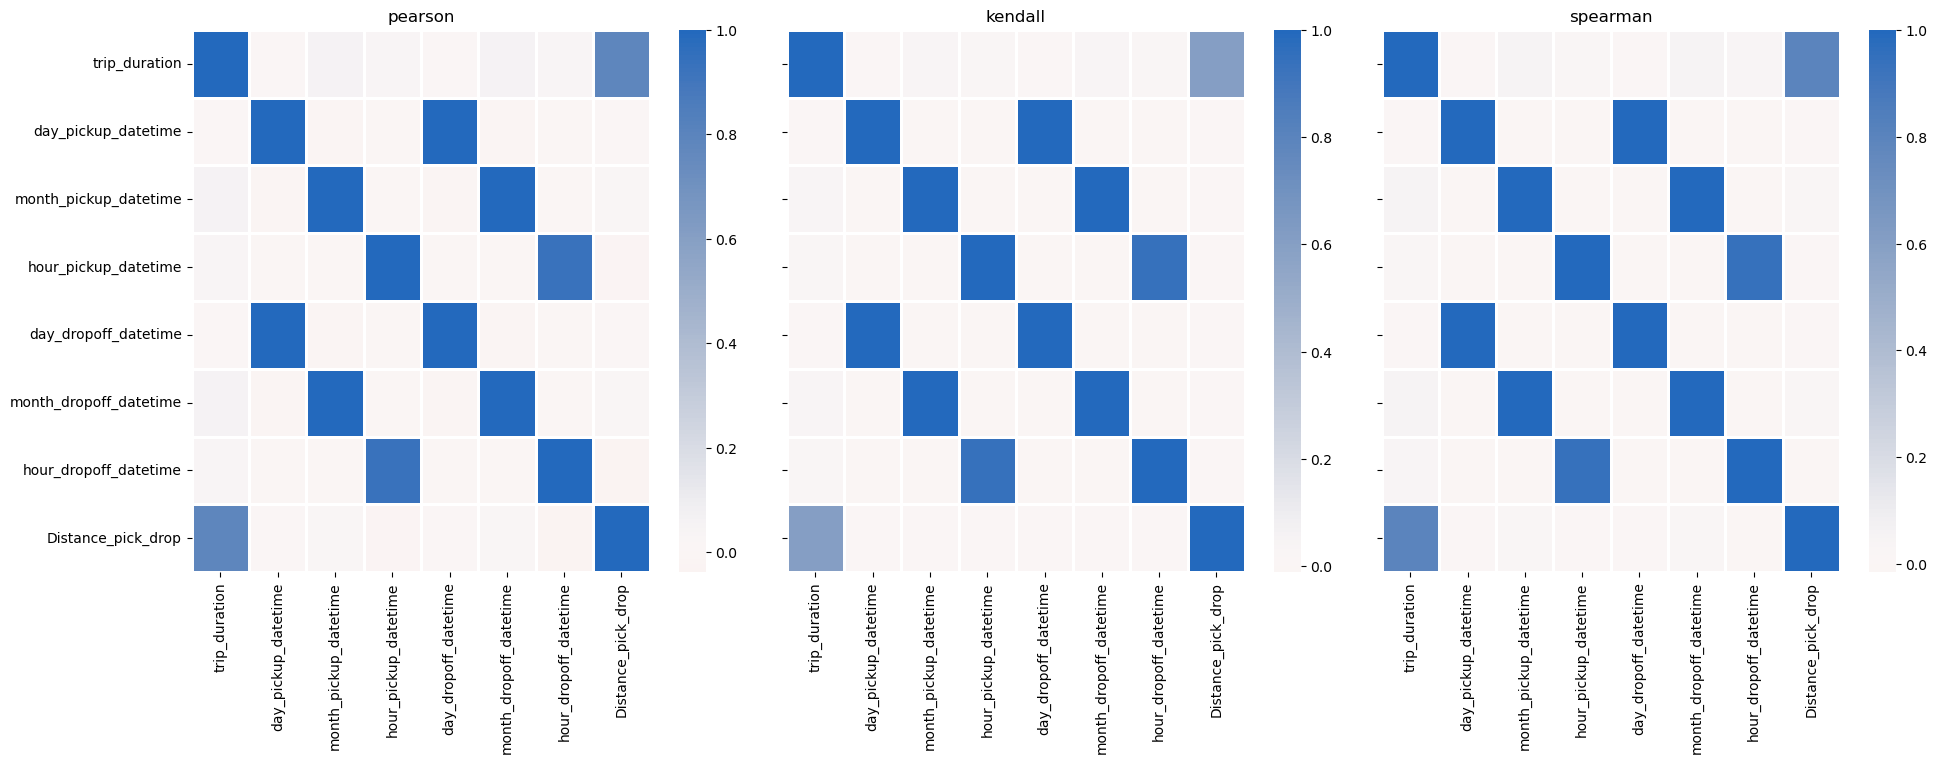

In [41]:
# plotting heatmap using all methods for all numerical variables
correlations = ['pearson','kendall','spearman']
fig, axes = plt.subplots(1, 3, figsize=(20,8), sharey='all')
for i, ax in enumerate(axes.ravel()):
    sb.heatmap(numerical.corr(method=correlations[i]), linewidths=2, cmap='vlag_r', center=0, ax=ax)
    axes[i].set_title(correlations[i])
plt.tight_layout(pad =2)

* Kendall and Spearman correlation seem to have very similar pattern between them, except the slight variation in magnitude of correlation.
*  Too many variables with insignificant correlation.But the day, month and hour of pickups are highly correlated to those of dropoff.
*  The distance_pick_drop is moderately correlated to trip duration by referring to Spearman comparison.

In [42]:
data.columns

Index(['passenger_count', 'trip_duration', 'day_pickup_datetime',
       'month_pickup_datetime', 'hour_pickup_datetime', 'day_dropoff_datetime',
       'month_dropoff_datetime', 'hour_dropoff_datetime', 'Distance_pick_drop',
       'day_moments'],
      dtype='object')

### Scatterplot

<Figure size 640x480 with 0 Axes>

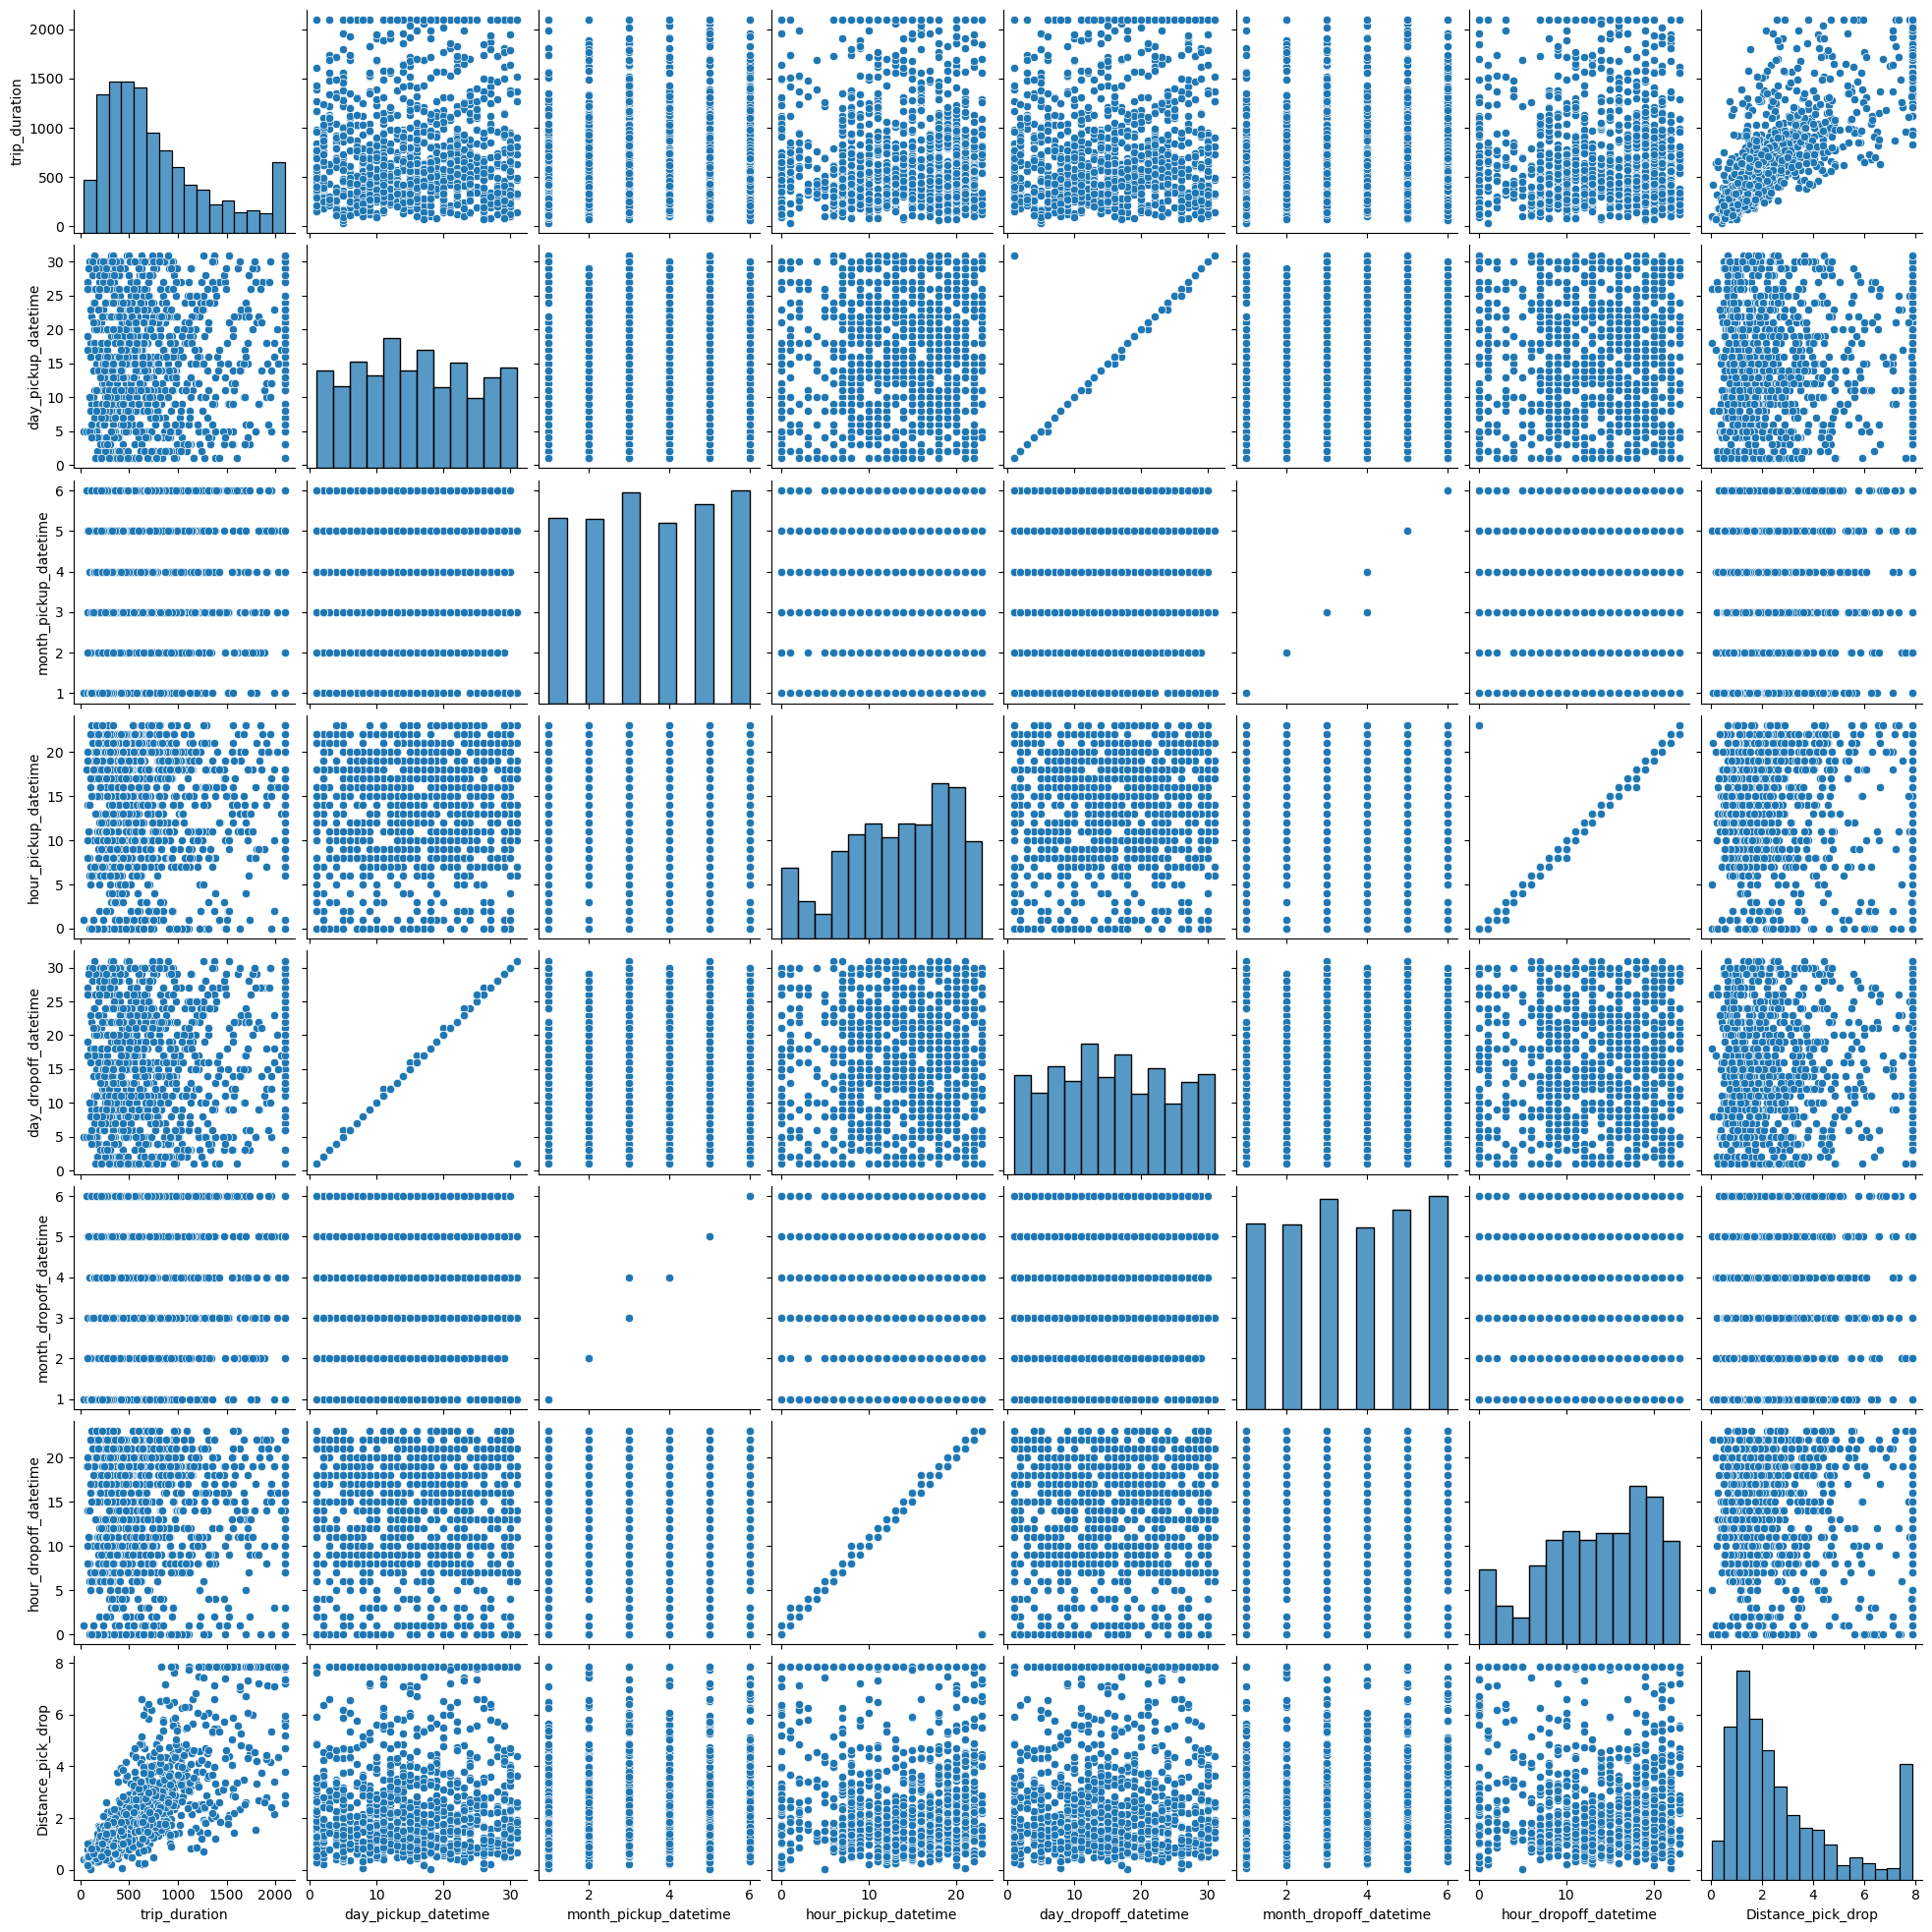

In [43]:
# scatter plot for a sample of trips
plt.figure()
sb.pairplot(numerical.sample(1000))

**The scatter plot is is not meaningful due to the presence of outliers.**

In [44]:
#taking log of every value to negate outliers
for column in numerical.columns.to_list():
    mini=1
    if numerical[column].min()<0:
        mini =  abs(numerical[column].min()) + 1
  
    numerical[column] = [i+mini for i in numerical[column]]
    numerical[column] = numerical[column].map(lambda x : np.log(x))

<Figure size 896x672 with 0 Axes>

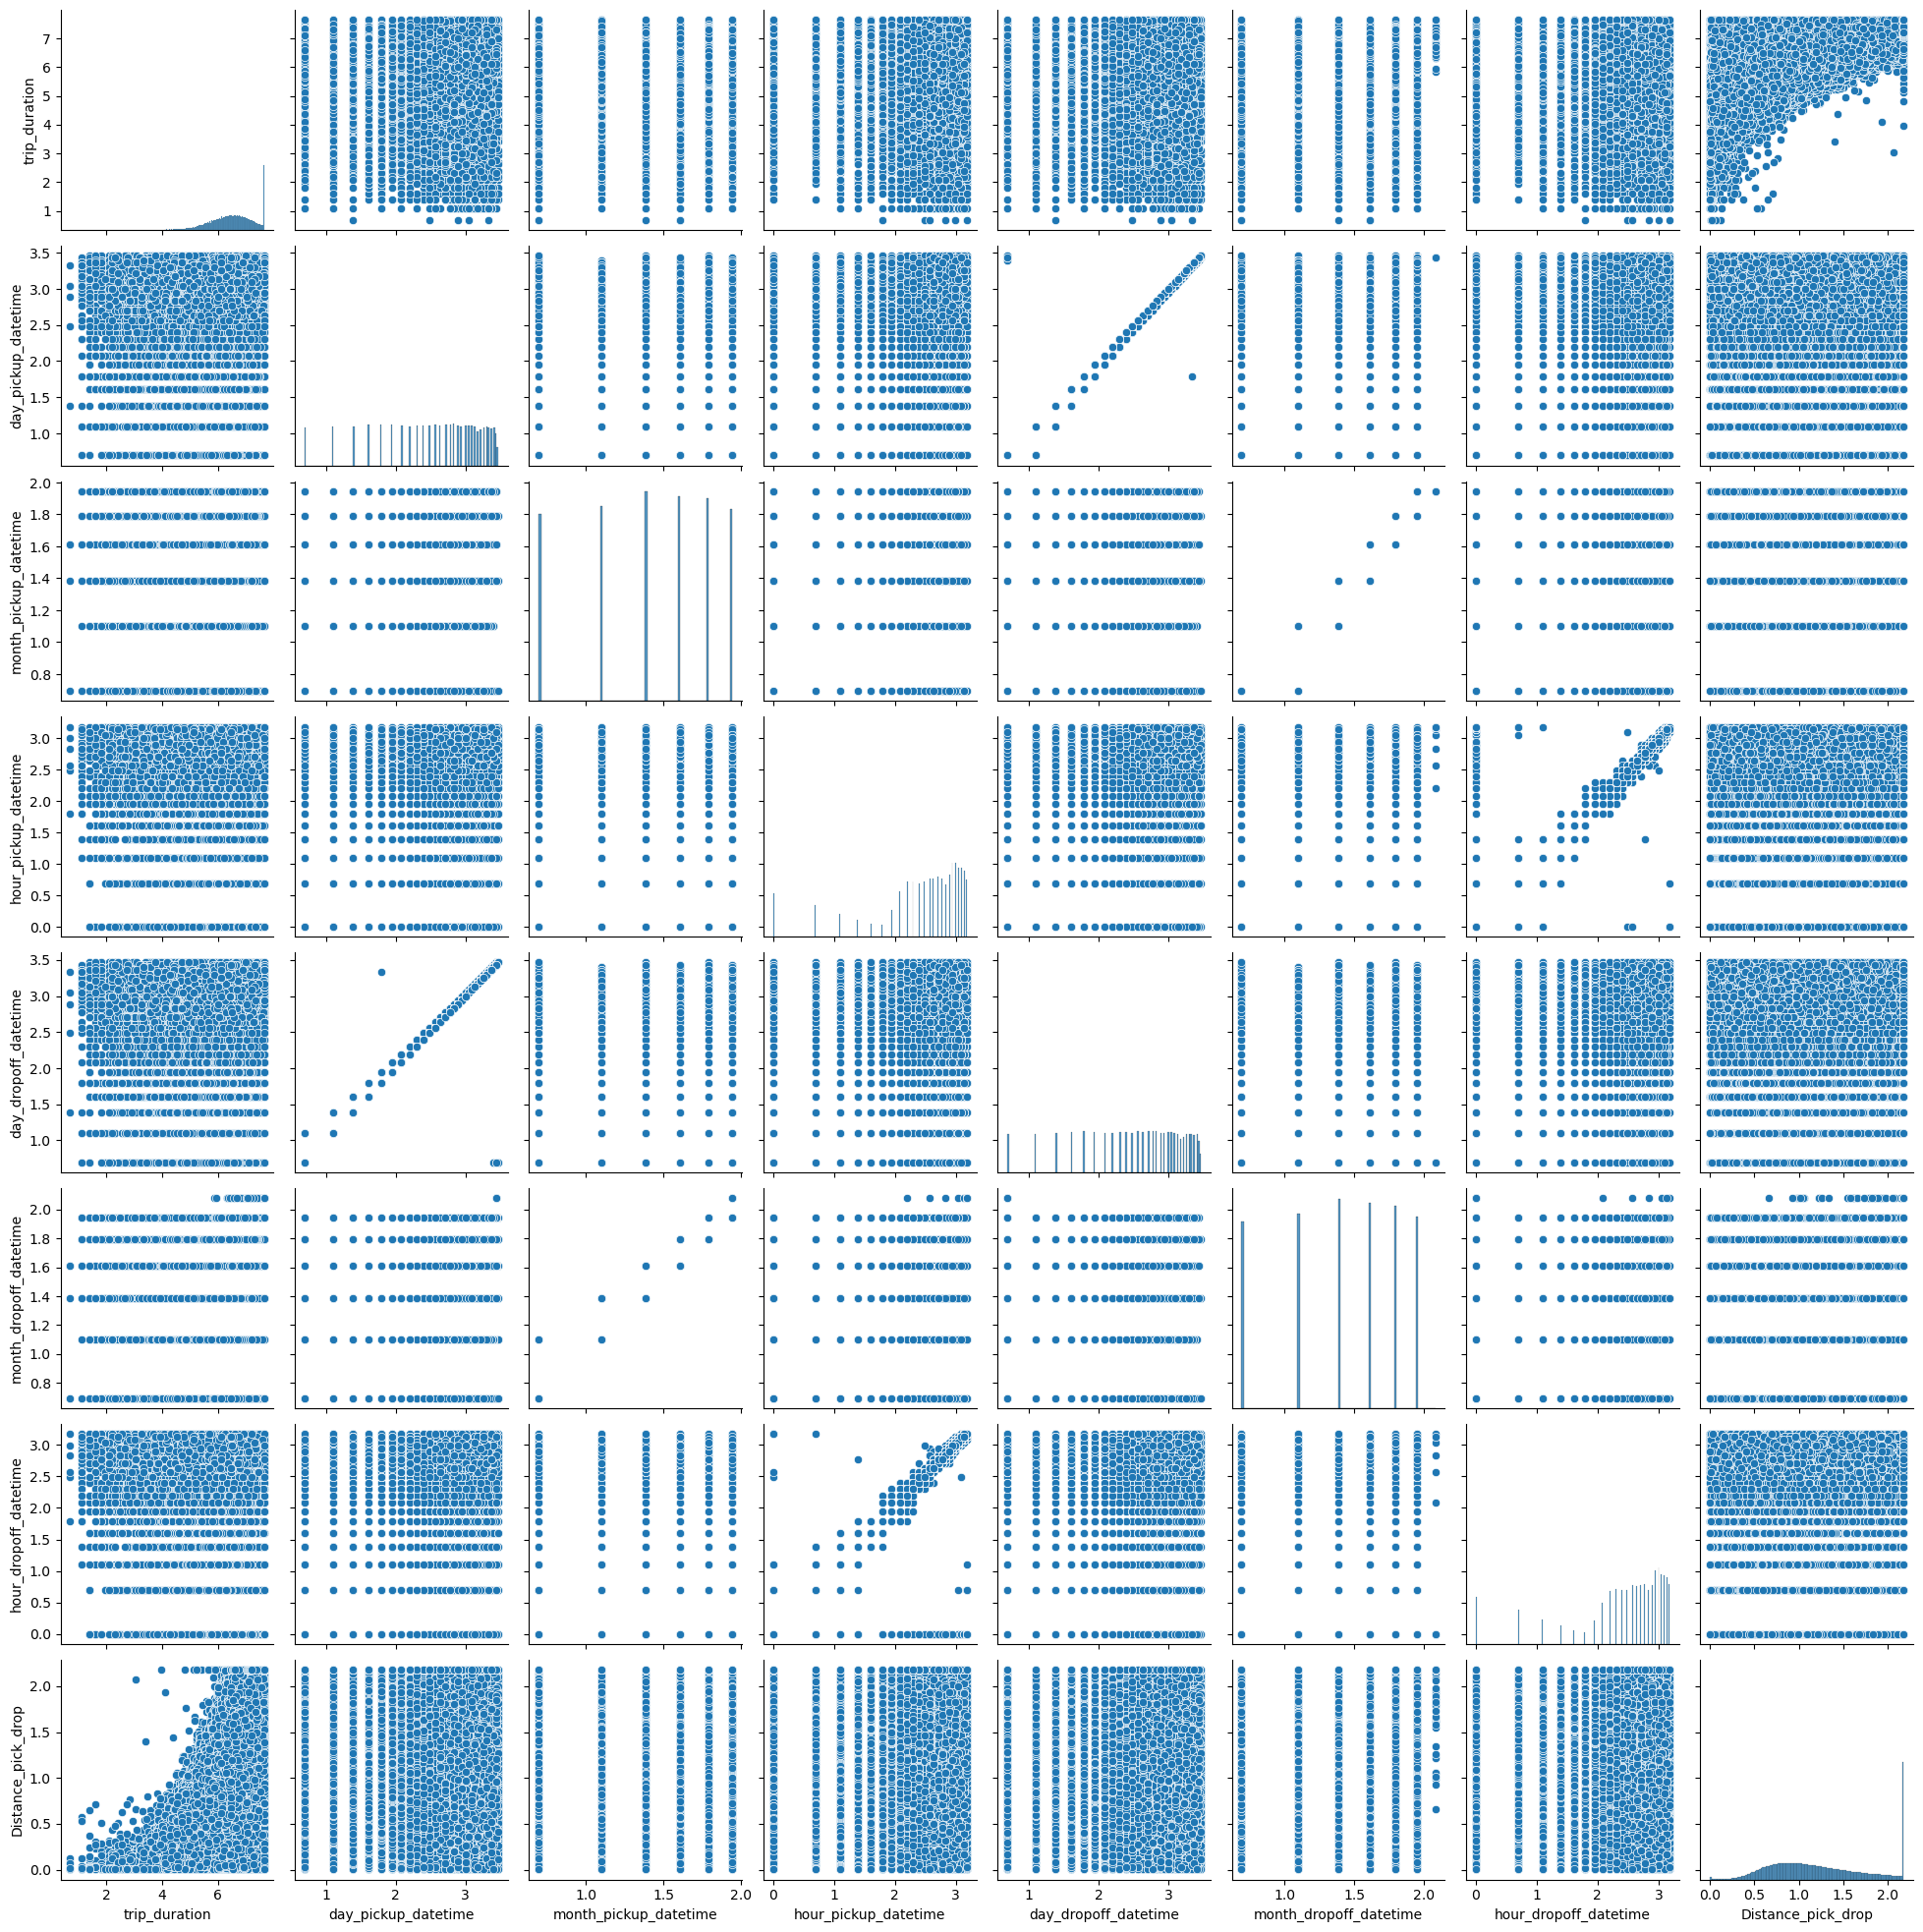

In [45]:
# scatter plot for trips
plt.figure(dpi=140)
sb.pairplot(numerical)

**Inferences**
1.    This validates the high correlation between the trip pickup and dropoff moments. But we have some outliers.
2.    The correlation between the trip duration and distance_pick_drop is not clear. We need to investigate.

## Bivariate : Categorical-Categorical

In [46]:
#Let's add a new category to understand the impact of distance
data['distance_slots'] = 'nothing'
data['distance_slots'][data.Distance_pick_drop <= 3] = 'Shortest_distance'
data['distance_slots'][(data.Distance_pick_drop > 3) & (data.Distance_pick_drop <= 9)] = 'Long_distance'
data['distance_slots'][data.Distance_pick_drop > 9] = 'Very_Long_distance'
data.head()

passenger_count  trip_duration  day_pickup_datetime  month_pickup_datetime  \
0               1          400.0                   29                      2   
1               2         1100.0                   11                      3   
2               2         1635.0                   21                      2   
3               6         1141.0                    5                      1   
4               1          848.0                   17                      2   

   hour_pickup_datetime  day_dropoff_datetime  month_dropoff_datetime  \
0                    16                    29                       2   
1                    23                    11                       3   
2                    17                    21                       2   
3                     9                     5                       1   
4                     6                    17                       2   

   hour_dropoff_datetime  Distance_pick_drop    day_moments     distance_slots  
0                     16            1.199073      Afternoon  Shortest_distance  
1                     23            4.129111        Evening      Long_distance  
2                     18            7.250753      Afternoon      Long_distance  
3                     10            2.361097  Early_morning  Shortest_distance  
4                      6            4.328534  Early_morning      Long_distance

#### List of Hypothesis to check under this combination

We know that trip duration is moderately correlated to distance between pickup and dropoff locations.

* Does the number of passengers affect the distance trip?
* Does the number of passengers increase during evening?
* Are the distances covered more long during evening?

In [47]:
d = data[['passenger_count','day_moments','distance_slots']]
t = pd.crosstab(d['day_moments'],d['distance_slots'])
t

distance_slots  Long_distance  Shortest_distance
day_moments                                     
Afternoon               53885             124192
Early_morning           35019              76410
Evening                 90159             159018
Full_night              40034              45223
Middle_morning          29184              72951

In [48]:
from scipy.stats import chi2_contingency

In [49]:
chi2_contingency(t)

Chi2ContingencyResult(statistic=9647.508415449713, pvalue=0.0, dof=4, expected_freq=array([[ 60893.3452288 , 117183.6547712 ],
       [ 38103.09341184,  73325.90658816],
       [ 85205.95632269, 163971.04367731],
       [ 29153.59049272,  56103.40950728],
       [ 34925.01454395,  67209.98545605]]))

In [50]:
pd.crosstab(d['day_moments'],d['distance_slots'], normalize='index')

distance_slots  Long_distance  Shortest_distance
day_moments                                     
Afternoon            0.302594           0.697406
Early_morning        0.314272           0.685728
Evening              0.361827           0.638173
Full_night           0.469568           0.530432
Middle_morning       0.285739           0.714261

In [51]:
def BVA_categorical_plot(data, tar, cat):
    '''
    take data and two categorical variables,
    calculates the chi2 significance between the two variables 
    and prints the result with countplot & CrossTab
    '''
    #isolating the variables
    data = data[[cat,tar]][:]

    #forming a crosstab
    table = pd.crosstab(data[tar],data[cat])

    chi, p, dof, expected = chi2_contingency(table)

    #checking whether results are significant
    if p<0.05:
        sig = True
    else:
        sig = False

    #plotting grouped plot
    sb.countplot(x=cat, hue=tar, data=data)
    plt.title(f"p-value = {round(p, 8)}\n difference significant? = {sig}\n")

    #plotting percent stacked bar plot
    ax1 = pd.crosstab(data[cat], data[tar], normalize='index')
    # ax1 = data.groupby(cat)[tar].value_counts(normalize=True).unstack() old code
    ax1.plot(kind='bar', stacked='True',title=str(ax1))
    # int_level = data[cat].value_counts() old code

**Are the distances traveled longer in the evening?**

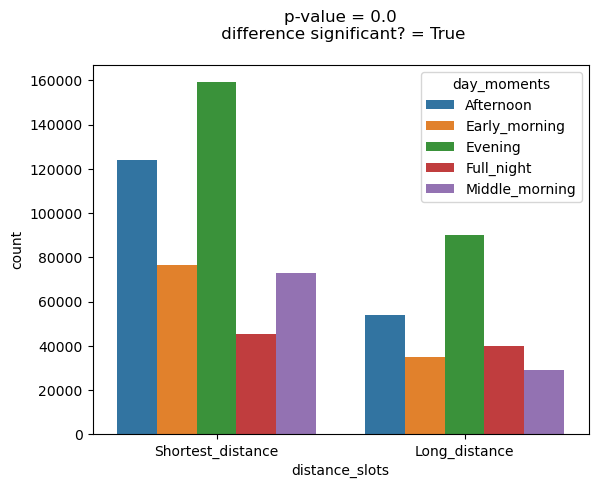

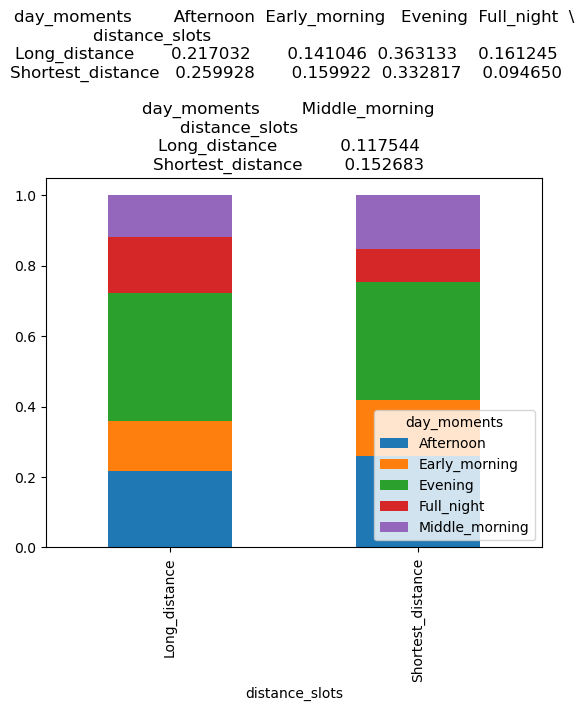

In [52]:
BVA_categorical_plot(data,'day_moments', 'distance_slots')

***Result:***

The difference between the distances by day moments is very significant.

**Does the number of passengers affect the distance trip?**

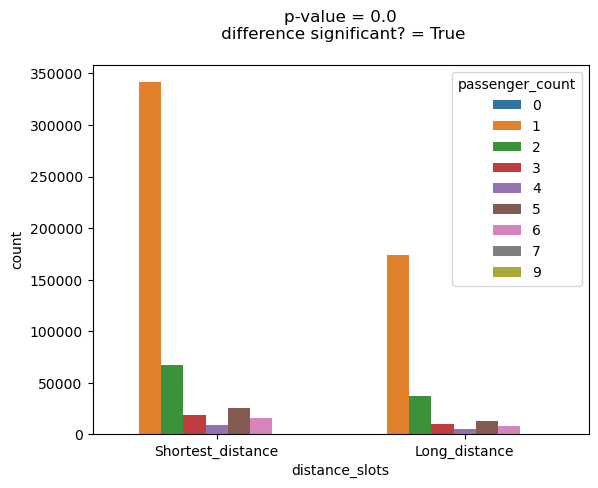

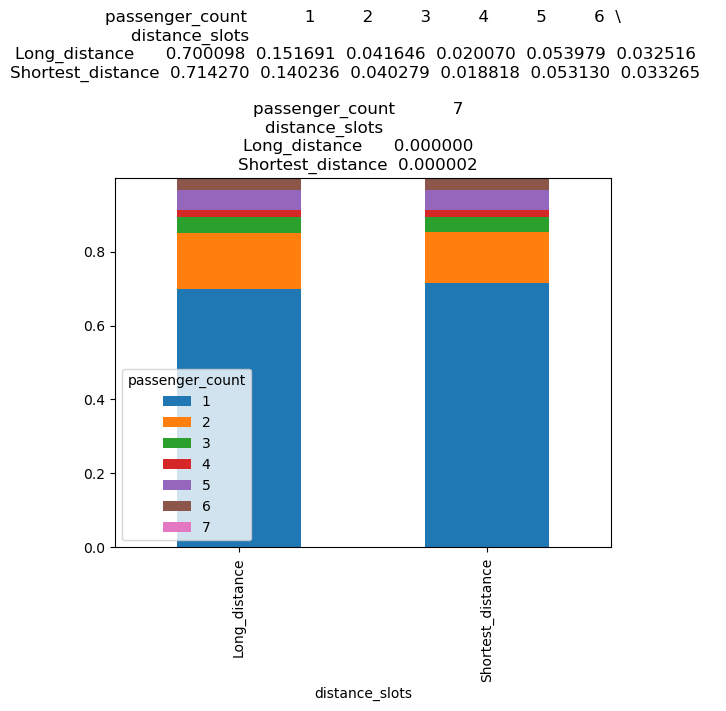

In [53]:
BVA_categorical_plot(data,'passenger_count', 'distance_slots')

***Result:***

The difference between the distances by passenger in taxi during trip is very significant.

**Does the number of passengers increase during evening?**

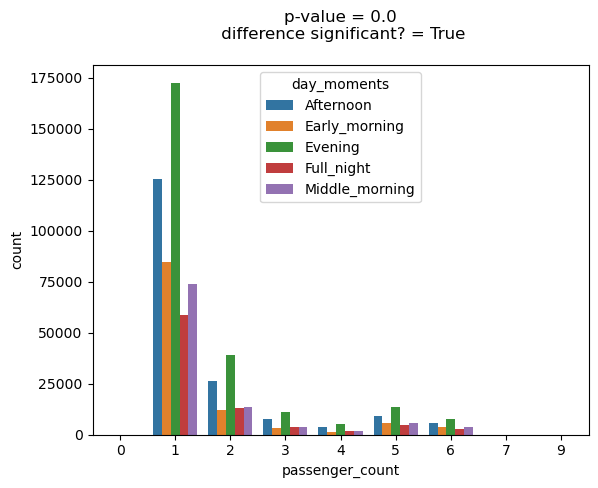

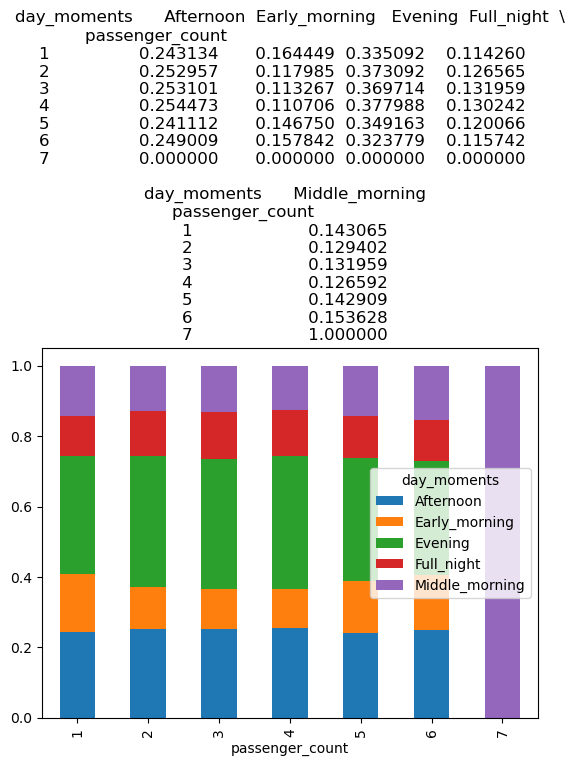

In [54]:
BVA_categorical_plot(data,'day_moments', 'passenger_count')

***Result:***

The difference between the number of passengers by day moments is very significant. We can see that most of long distance are made during evening and taxi take between 2 and 4 passengers. As the distance increases, the number of passengers decreases.

## Bivariate : Categorical-Numerical

#### List of Hypothesis to check under this combination
* Is the trip faster at night or during the day?
* Does the number of passengers affect the duration trip?


In [55]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
    '''
      Takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
    '''
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
    z = (X1 - X2)/ovr_sigma
    pval = 2*(1 - norm.cdf(abs(z)))
    return pval

In [56]:
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
    '''
    takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sample T-Test
    '''
    from numpy import sqrt, abs, round
    from scipy.stats import t as t_dist
    ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
    t = (X1 - X2)/ovr_sd
    df = n1+n2-2
    pval = 2*(1 - t_dist.cdf(abs(t),df))
    return pval

In [57]:
def Bivariate_cont_cat(data, cont, cat, category,mul_cat=False):
    from itertools import combinations
    #creating 2 samples
    if mul_cat==False:
        x1 = data[cont][data[cat]==category][:]
        x2 = data[cont][~(data[cat]==category)][:]
        n1, n2 = x1.shape[0], x2.shape[0]
        m1, m2 = x1.mean(), x2.mean()
        std1, std2 = x1.std(), x2.std()
        print('Frist group mean :{}\t'.format(m1),'Second group mean :{}\t'.format(m2))
        #calculating p-values
        t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
        z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)
         #table
        table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)
        #plotting
        plt.figure(figsize = (15,6), dpi=140)
  
        sb.barplot(y =['First_ Group {}'.format(category)+' of {}'.format(cat),'Second_ Group'], x = [m1,m2])
        plt.ylabel('mean {}'.format(cont))
        plt.xlabel(cat)
        plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                z_p_val,
                                                                table))

    else:
        var_cat = list(combinations(data[cat].value_counts().reset_index().iloc[:]['index'].values.to_list(),2))
        for j, i in enumerate(var_cat):
            x1 = data[cont][data[cat] == i[0]][:]
            x2 = data[cont][data[cat] == i[1]][:]
            n1, n2 = x1.shape[0], x2.shape[0]
            m1, m2 = x1.mean(), x2.mean()
            std1, std2 = x1.std(), x2.std()
            print('Group {}\n First group mean : {}'.format(i,m1),'Second group mean :{}\t'.format(m2))
            #calculating p-values
            try:
                t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
                z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)
                print('\nt-test p-value = {} \n z-test p-value = {}\n'.format(t_p_val,z_p_val))
            except:
                pass
        #table
        table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)
        #plotting
        plt.figure(figsize = (15,6), dpi=140)
        print(table)
                  
        # boxplot
        plt.subplot(1,2,1)
        sb.boxplot(x=cat, y=cont, data=data)
        plt.xticks(rotation = 45 )
    
        #Full Overview
        plt.subplot(1,2,2)
        sb.barplot(x=cat, y=cont, data=data)
        plt.tight_layout(pad = 3)
        plt.title('categorical boxplot')
        plt.xticks(rotation = 45 )

**Does the number of passengers affect the duration trip?**
*1 passenger vs more than 1 passenger*

Frist group mean :793.3679156272144	 Second group mean :826.0496492558536	


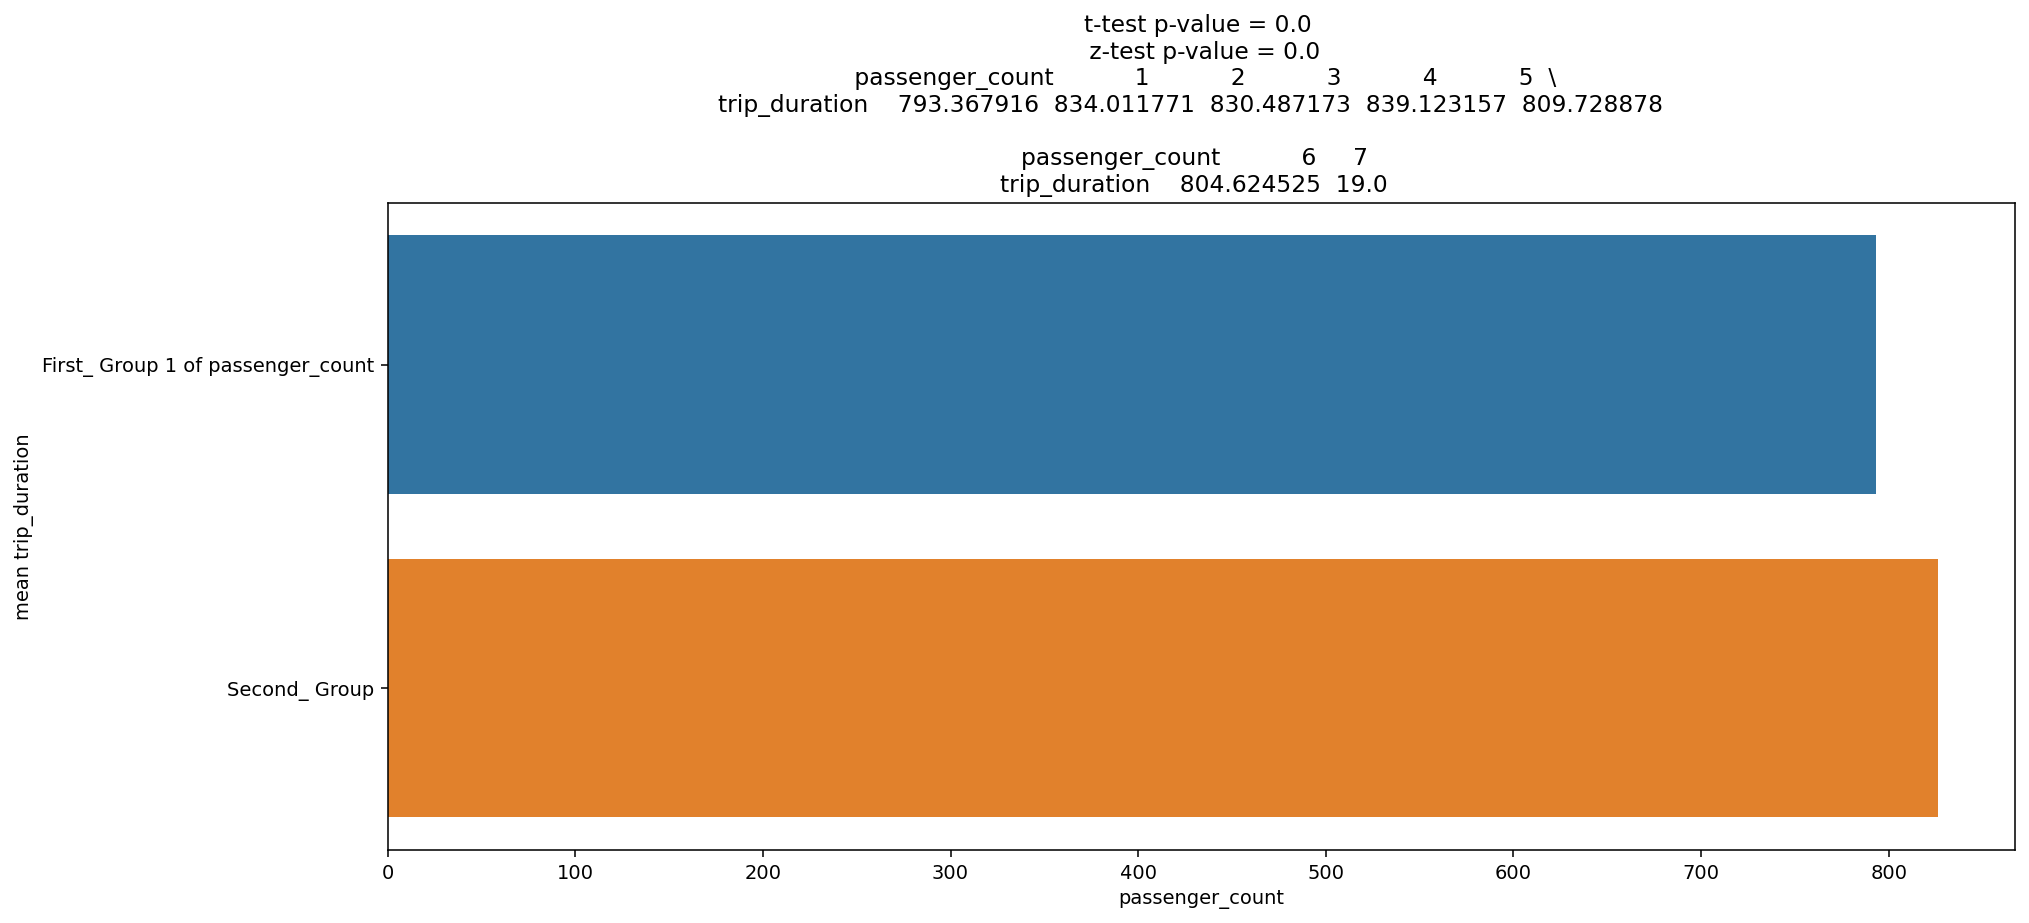

In [58]:
Bivariate_cont_cat(data,'trip_duration','passenger_count',1)

***Result:***

The difference between the trip duration with 1 passenger and more is very significant.

**Does the number of passengers affect the duration trip?**
* At most 2 passenger vs more than 2 passenger.

Group (1, 2)
 First group mean : 793.3679156272144 Second group mean :834.01177077561	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group (1, 5)
 First group mean : 793.3679156272144 Second group mean :809.7288782323975	

t-test p-value = 5.593874918830011e-09 
 z-test p-value = 5.5907924956244415e-09

Group (1, 3)
 First group mean : 793.3679156272144 Second group mean :830.487172553659	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group (1, 6)
 First group mean : 793.3679156272144 Second group mean :804.6245253890767	

t-test p-value = 0.001302136696163636 
 z-test p-value = 0.0013020599805282362

Group (1, 4)
 First group mean : 793.3679156272144 Second group mean :839.1231572921139	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group (1, 7)
 First group mean : 793.3679156272144 Second group mean :19.0	

t-test p-value = nan 
 z-test p-value = nan

Group (1, 0)
 First group mean : 793.3679156272144 Second group mean :nan	
Group (1, 9)
 First group mean : 793.3679156272144 Second g

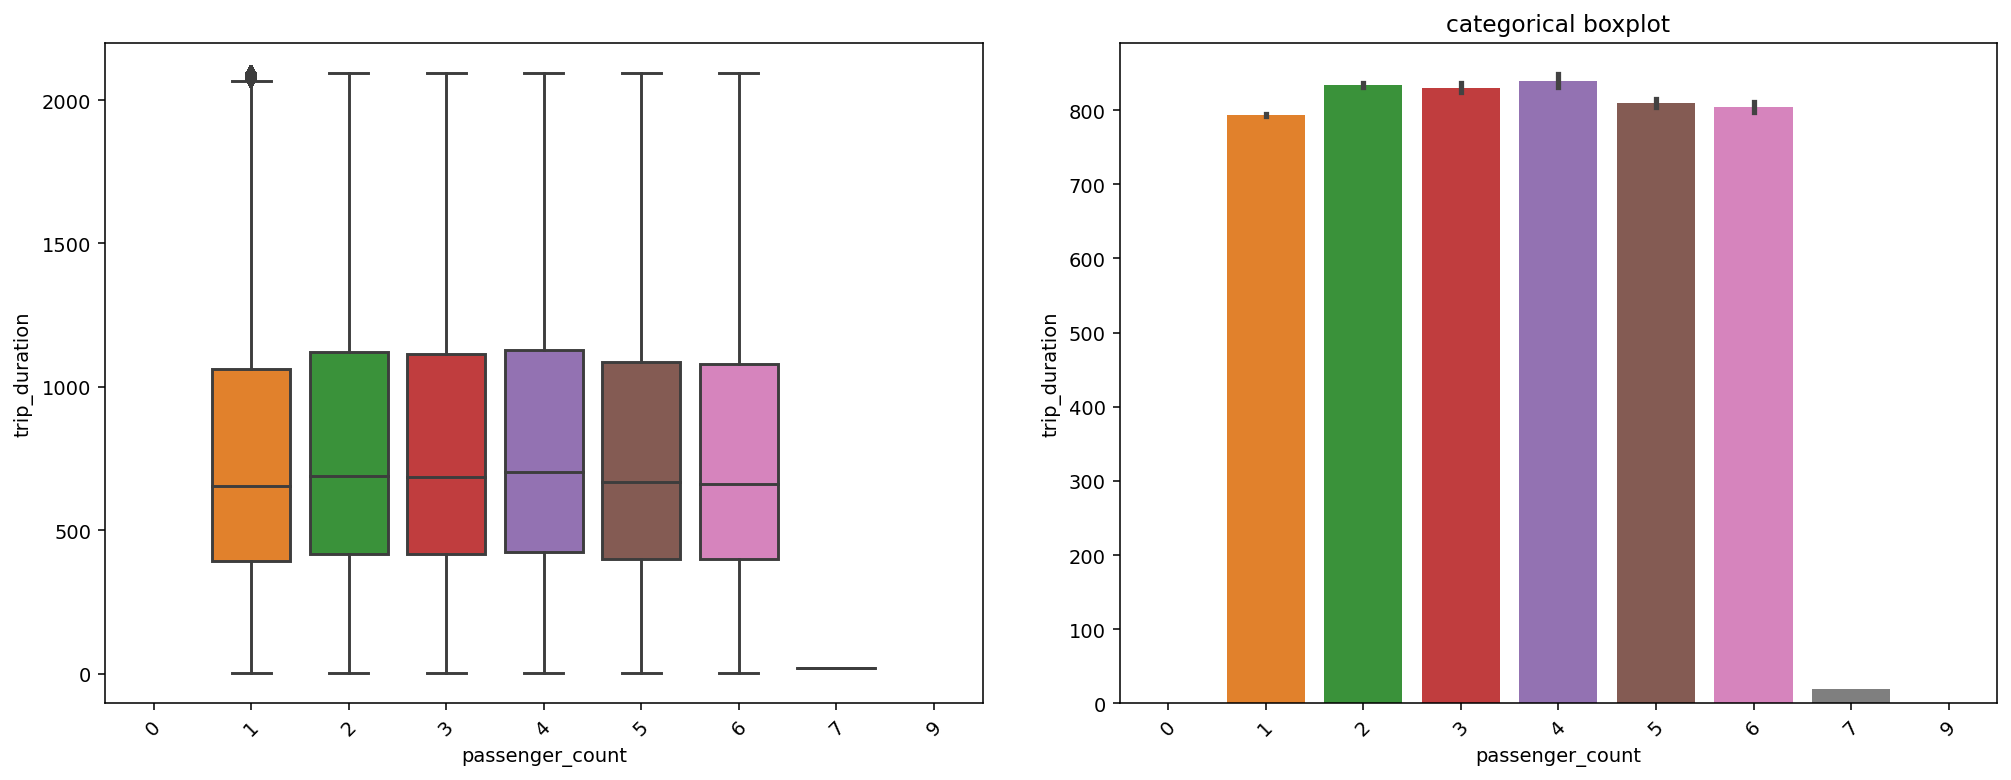

In [59]:
Bivariate_cont_cat(data,'trip_duration','passenger_count',1,mul_cat=True)

***Result:***

The difference between the trip duration with 2 passengers and 3 up to 4 passengers is not significant. But from 5 passengers the trip duration decreases significantly compared to with 2, 3, 4. Therefore the difference between taxi travel time with 5 and 6 passengers is not significant.

**Does the day moment affect the duration trip?**


Frist group mean :869.4746177215475	 Second group mean :781.2188548133387	


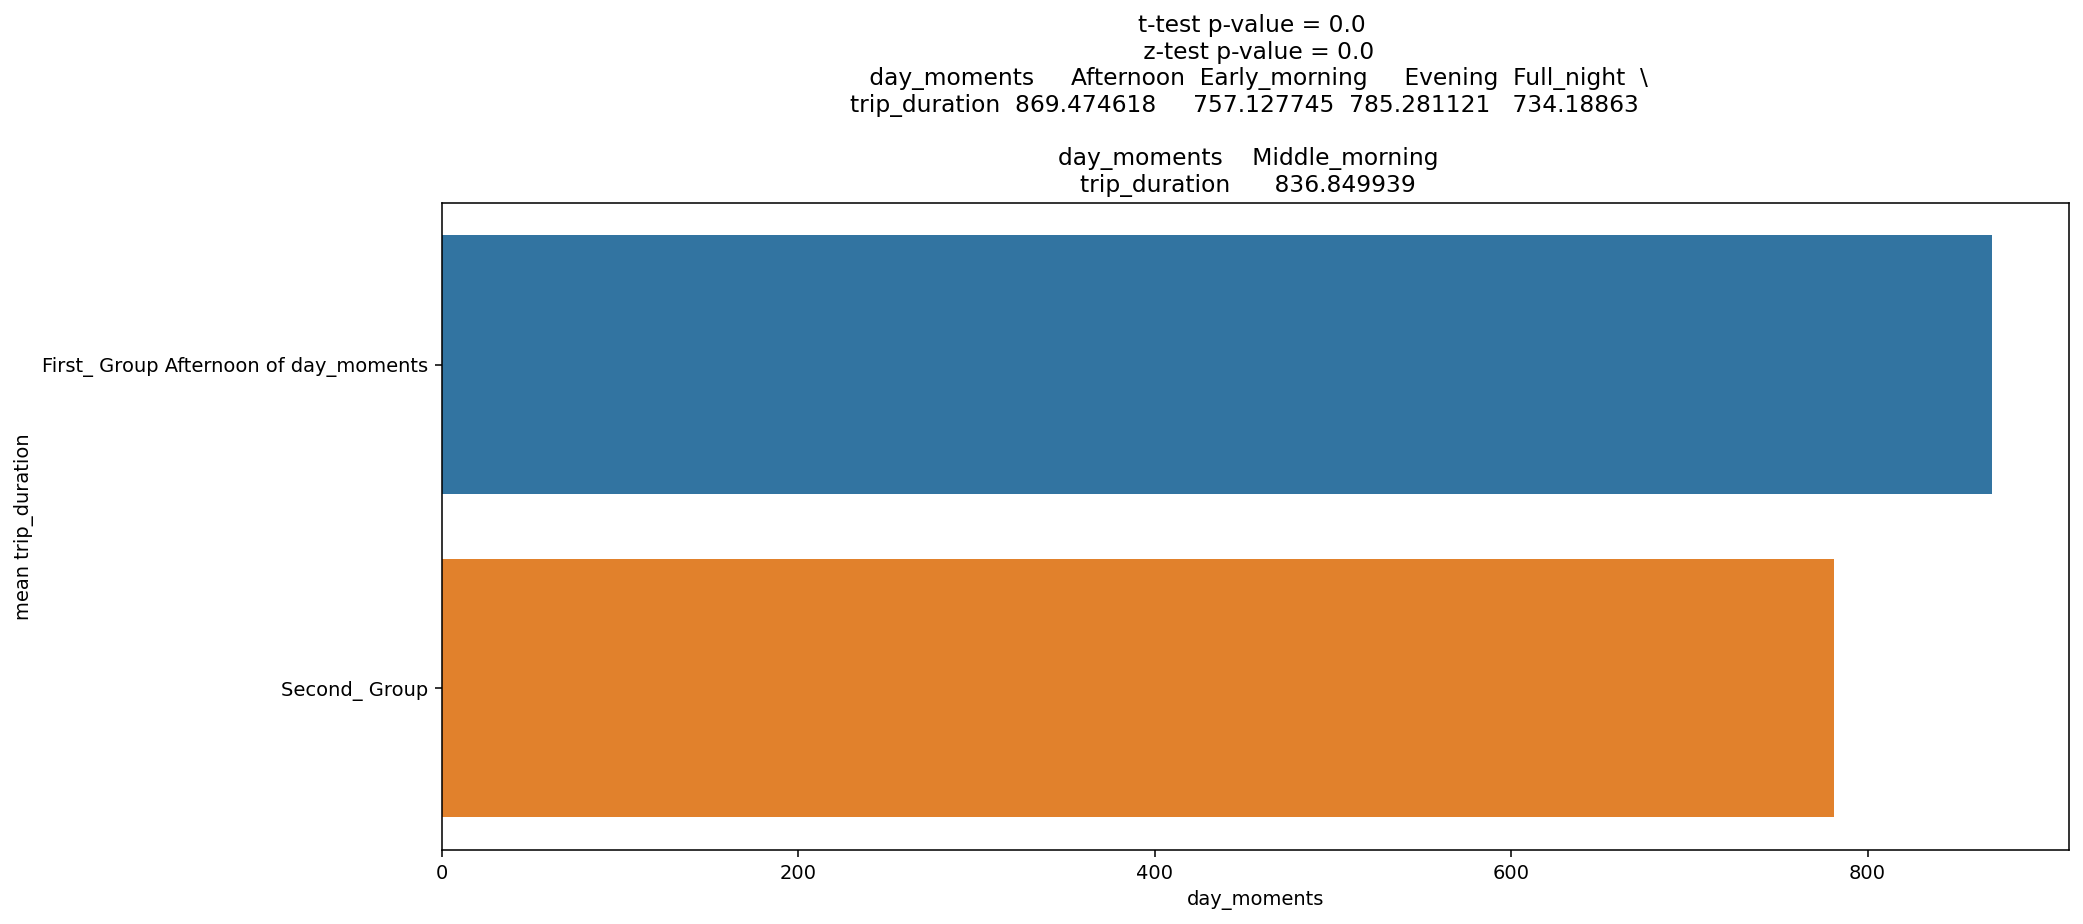

In [60]:
Bivariate_cont_cat(data,'trip_duration','day_moments','Afternoon')

Group ('Evening', 'Afternoon')
 First group mean : 785.2811214518194 Second group mean :869.4746177215475	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Evening', 'Early_morning')
 First group mean : 785.2811214518194 Second group mean :757.1277450214935	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Evening', 'Middle_morning')
 First group mean : 785.2811214518194 Second group mean :836.8499388064816	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Evening', 'Full_night')
 First group mean : 785.2811214518194 Second group mean :734.1886296726368	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Afternoon', 'Early_morning')
 First group mean : 869.4746177215475 Second group mean :757.1277450214935	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Afternoon', 'Middle_morning')
 First group mean : 869.4746177215475 Second group mean :836.8499388064816	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Afternoon', 'Full_night')
 First group mean : 869.4

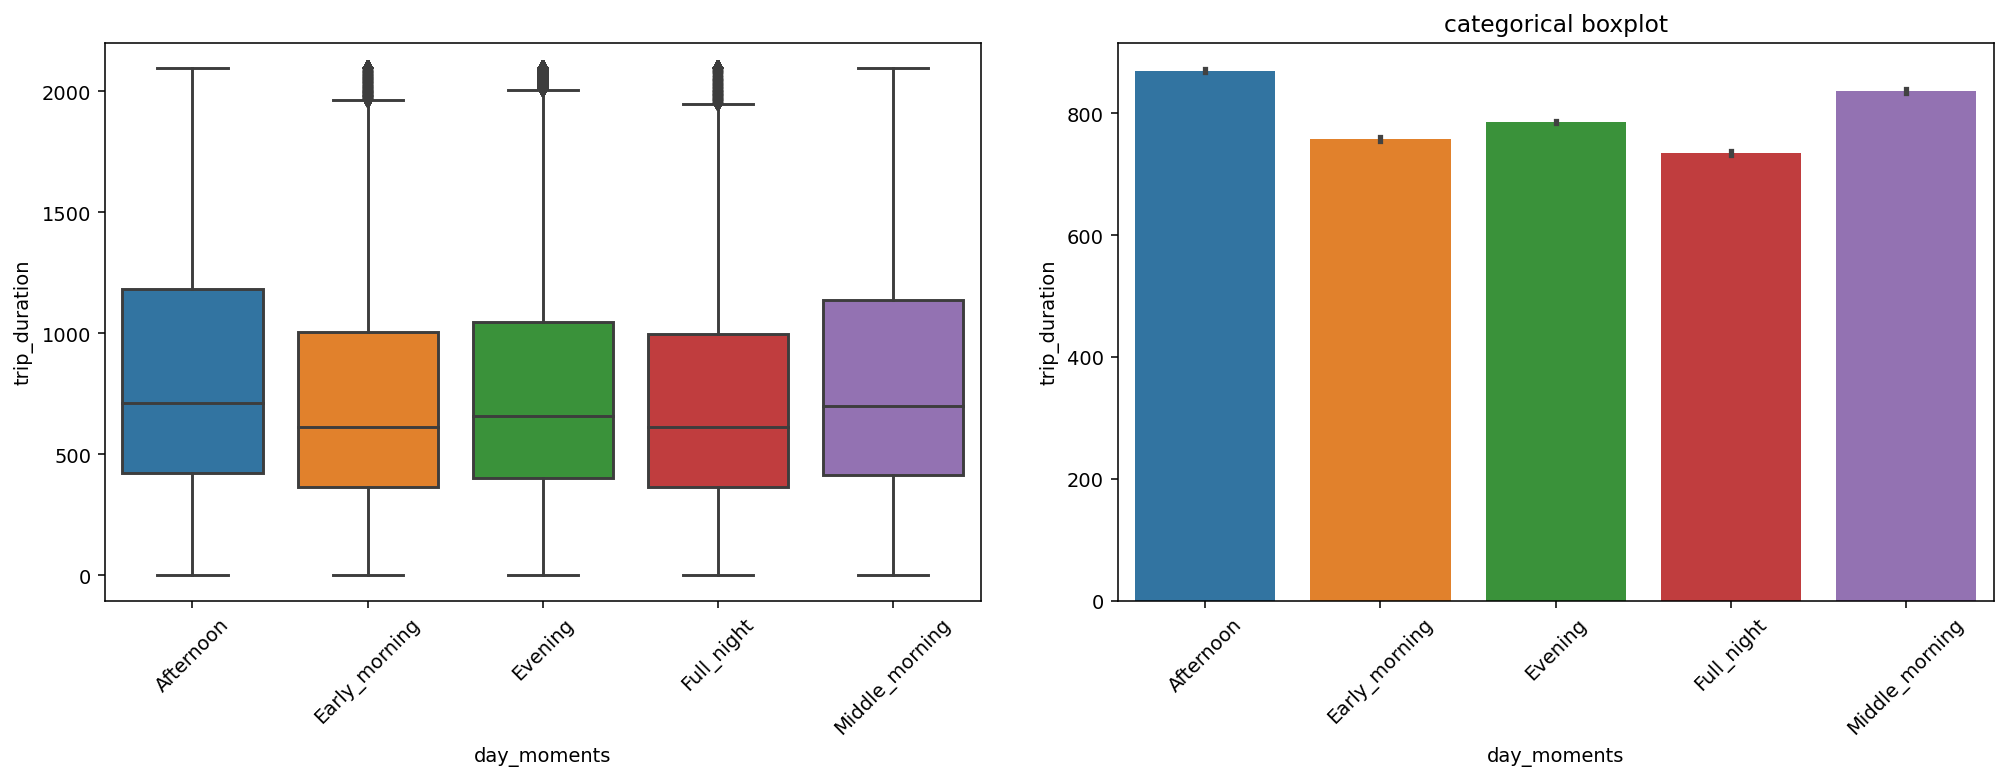

In [61]:
Bivariate_cont_cat(data,'trip_duration','day_moments','',mul_cat=True)

***Result:***

The difference between the trip duration during day and by night is significant. Also between all others day moments.


**Does the day moment affect the distance trip?**

Frist group mean :3.559605994755622	 Second group mean :2.8309165057969374	


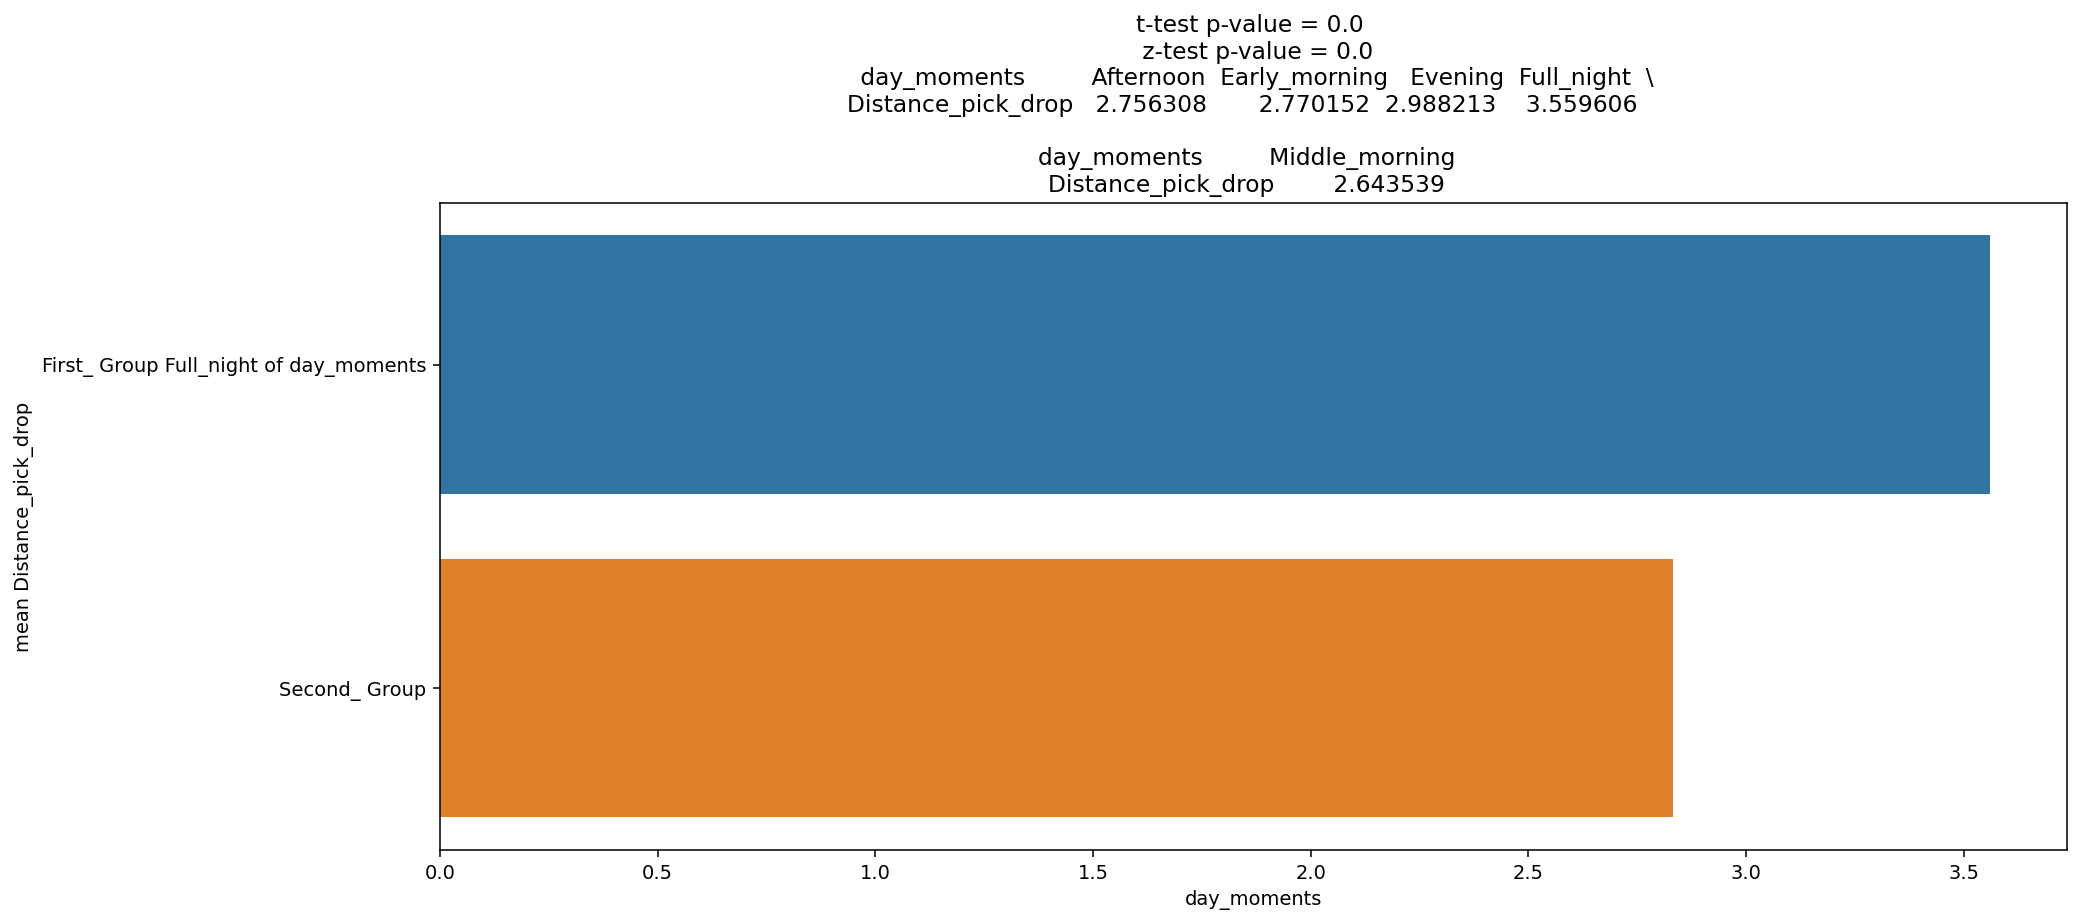

In [62]:
Bivariate_cont_cat(data,'Distance_pick_drop','day_moments','Full_night')

Group ('Evening', 'Afternoon')
 First group mean : 2.9882132421088405 Second group mean :2.7563083575586003	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Evening', 'Early_morning')
 First group mean : 2.9882132421088405 Second group mean :2.7701515895029845	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Evening', 'Middle_morning')
 First group mean : 2.9882132421088405 Second group mean :2.643539408891524	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Evening', 'Full_night')
 First group mean : 2.9882132421088405 Second group mean :3.559605994755622	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Afternoon', 'Early_morning')
 First group mean : 2.7563083575586003 Second group mean :2.7701515895029845	

t-test p-value = 0.09828097348949871 
 z-test p-value = 0.09827988922634279

Group ('Afternoon', 'Middle_morning')
 First group mean : 2.7563083575586003 Second group mean :2.643539408891524	

t-test p-value = 0.0 
 z-test p-value = 0.0

Group ('Afternoon'

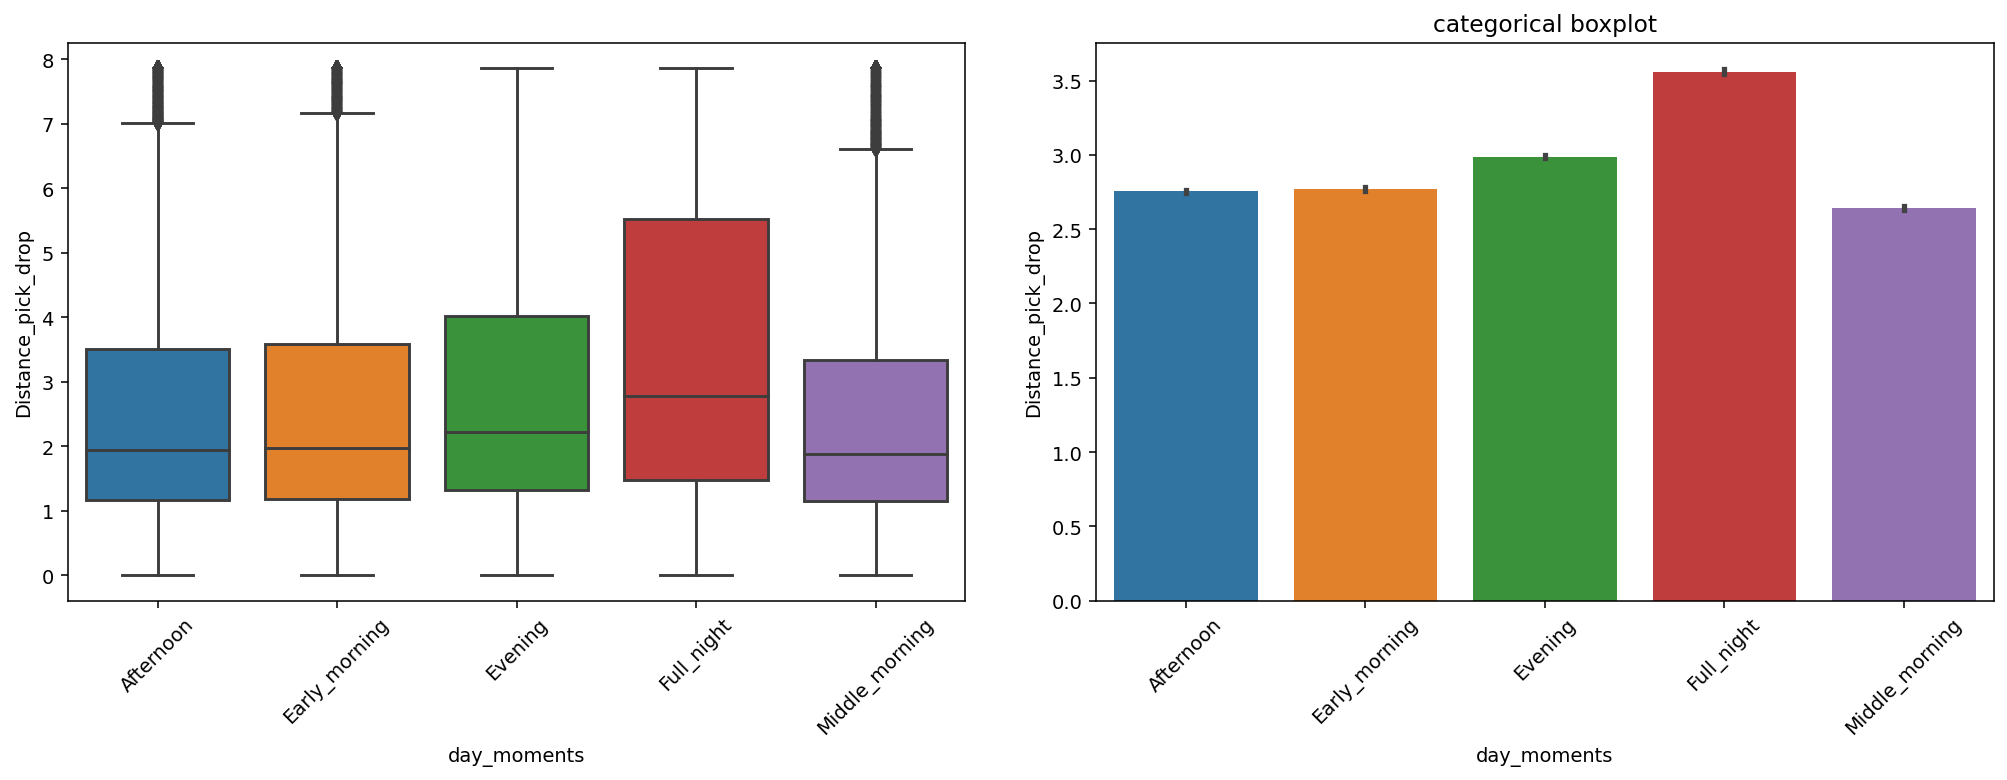

In [63]:
Bivariate_cont_cat(data,'Distance_pick_drop','day_moments','',mul_cat=True)

> #### Summary of categorical-continuous bivariate analysis

* The difference between the trip duration with 2 passengers and 3 up to 4 passengers is not significant. But from 5 passengers the trip duration increases significantly. Except for 7 and 9 passengers which have very low occurences.

* The difference between the trip duration during day and by night is significant. Also between trip duration for evening and middle morning, and also between all others day moments. 
* As expected the trip duration increases with the distance traveled.
* The difference between the trip distance with 1 and more passengers is significant. The difference between the trip duration with 2 passengers and 3 up to 4 passengers is not significant. But from 5 passengers the trip duration decreases significantly compared to with 2, 3, 4. Therefore the difference between taxi travel time with 5 and 6 passengers is not significant.


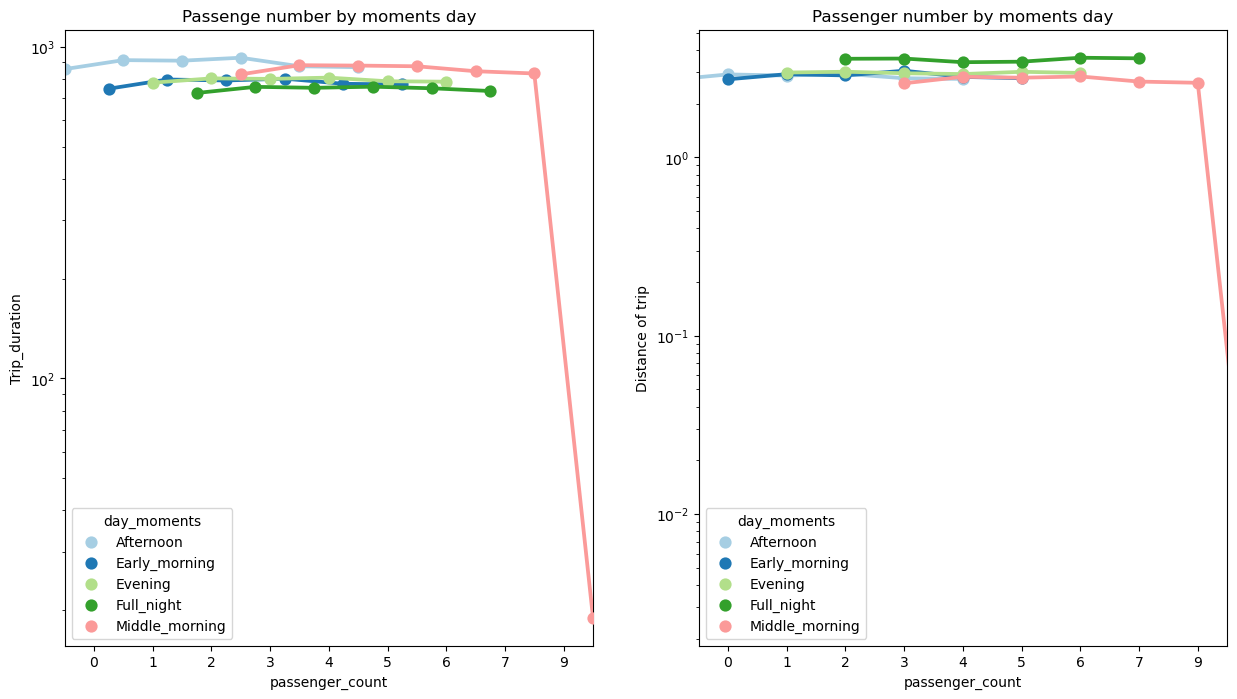

In [64]:
fig,ax =plt.subplots(ncols=2,figsize = [15,8] )
sb.pointplot(data = data, x = 'passenger_count', y = 'trip_duration', hue = 'day_moments',
           palette = 'Paired',linestyles='-',dodge = 3,errorbar=None, ax=ax[0])
ax[0].set_title('Passenge number by moments day')
ax[0].set_ylabel('Trip_duration')
ax[0].set_yscale('log')


sb.pointplot(data = data, x = 'passenger_count', y = 'Distance_pick_drop', hue = 'day_moments',
           palette = 'Paired',linestyles='-',dodge = 4,errorbar=None, ax=ax[1])
ax[1].set_title('Passenger number by moments day')
ax[1].set_ylabel('Distance of trip')
ax[1].set_yscale('log')


plt.show();

> #### Full summary of EDA

* There is similar relation between the pickup and dropoff moments.
* The outliers are in number in data. We should manage them to justify the pickup and dropoff moments.
* We removed from data , trips without passengers.
* Too many variables with insignificant correlation.But the day, month and hour of pickups are highly correlated to those of dropoff.
* The distance_pick_drop is moderately correlated to trip duration by referring to Spearman comparison.
* The difference between the distances by day moments is very significant.
* The difference between the number of passengers by day moments is very significant. We can see that most of long distance are made during evening by taxi having between 2 and 4 passengers. As the distance increases, the number of passengers decreases.
* The difference between the trip duration during day and by night is significant. Also between trip duration for evening and middle morning, and also between all others day moments. 
* As expected the trip duration increases with the distance traveled.
* The difference between the trip distance with 1 and more passengers is significant. The difference between the trip duration with 2 passengers and 3 up to 4 passengers is not significant. But from 5 passengers the trip duration decreases significantly compared to with 2, 3, 4. Therefore the difference between taxi travel time with 5 and 6 passengers is not significant.


In [65]:
data.to_csv('./trip_data.csv',index = False)